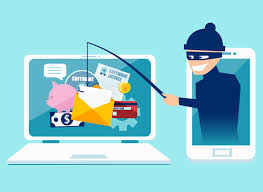
# **PHISHING DETECTION THROUGH MACHINE LEARNING**

In [2]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.8 MB/s eta 0:00:00


In [3]:
# Standard Libraries
import os
import time
import re
from collections import defaultdict
from functools import partial
from concurrent.futures import ThreadPoolExecutor
import multiprocessing

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    learning_curve,
    GridSearchCV,
    KFold
)
from sklearn.utils import shuffle

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.calibration import CalibratedClassifierCV

# Nearest Neighbors
from sklearn.neighbors import NearestNeighbors

# External Libraries
from tqdm import tqdm
from rapidfuzz import fuzz as rapidfuzz

# Model Persistence
import joblib


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
def prepare_features(df):
    # Remove identifier columns and high-cardinality text fields
    drop_cols = ['FILENAME', 'URL', 'Domain', 'Title', 'TLD']
    df = df.drop(columns=drop_cols)

    # # Convert boolean columns to int
    # bool_cols = df.select_dtypes(include=['bool']).columns
    # df[bool_cols] = df[bool_cols].astype(int)

    return df

In [6]:
data=pd.read_csv('/content/drive/My Drive/url_phising_prj/PhiUSIIL_Phishing_URL_Dataset.csv')

In [7]:
data

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.000000,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.000000,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.000000,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.000000,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.000000,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235790,660997.txt,https://www.skincareliving.com,29,www.skincareliving.com,22,0,com,100.000000,1.000000,0.522907,...,1,0,1,51,7,21,187,2,191,1
235791,77185.txt,https://www.winchester.gov.uk,28,www.winchester.gov.uk,21,0,uk,100.000000,0.785714,0.028555,...,1,0,0,50,1,7,88,0,31,1
235792,622132.txt,https://www.nononsensedesign.be,30,www.nononsensedesign.be,23,0,be,100.000000,1.000000,0.003319,...,0,0,1,27,10,30,58,2,67,1
235793,7503962.txt,https://patient-cell-40f5.updatedlogmylogin.wo...,55,patient-cell-40f5.updatedlogmylogin.workers.dev,47,0,dev,28.157537,0.465116,0.000961,...,0,0,0,0,0,3,0,0,0,0


In [8]:
df=prepare_features(data)
df

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,100.000000,1.000000,0.522907,0.061933,3,1,0,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,100.000000,0.666667,0.032650,0.050207,2,1,0,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,100.000000,0.866667,0.028555,0.064129,2,2,0,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,100.000000,1.000000,0.522907,0.057606,3,1,0,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,100.000000,1.000000,0.079963,0.059441,3,1,0,...,1,0,1,244,15,34,72,1,85,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235790,29,22,0,100.000000,1.000000,0.522907,0.058739,3,1,0,...,1,0,1,51,7,21,187,2,191,1
235791,28,21,0,100.000000,0.785714,0.028555,0.053834,2,2,0,...,1,0,0,50,1,7,88,0,31,1
235792,30,23,0,100.000000,1.000000,0.003319,0.063093,2,1,0,...,0,0,1,27,10,30,58,2,67,1
235793,55,47,0,28.157537,0.465116,0.000961,0.050211,3,2,0,...,0,0,0,0,0,3,0,0,0,0


In [9]:
drop_cols = ['FILENAME', 'Domain', 'Title', 'TLD']
df_withURL = data.drop(columns=drop_cols)

In [10]:
df_withURL

,URL,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,24,0,100.000000,1.000000,0.522907,0.061933,3,1,...,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,16,0,100.000000,0.666667,0.032650,0.050207,2,1,...,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,22,0,100.000000,0.866667,0.028555,0.064129,2,2,...,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,19,0,100.000000,1.000000,0.522907,0.057606,3,1,...,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,26,0,100.000000,1.000000,0.079963,0.059441,3,1,...,1,0,1,244,15,34,72,1,85,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235790,https://www.skincareliving.com,29,22,0,100.000000,1.000000,0.522907,0.058739,3,1,...,1,0,1,51,7,21,187,2,191,1
235791,https://www.winchester.gov.uk,28,21,0,100.000000,0.785714,0.028555,0.053834,2,2,...,1,0,0,50,1,7,88,0,31,1
235792,https://www.nononsensedesign.be,30,23,0,100.000000,1.000000,0.003319,0.063093,2,1,...,0,0,1,27,10,30,58,2,67,1
235793,https://patient-cell-40f5.updatedlogmylogin.wo...,55,47,0,28.157537,0.465116,0.000961,0.050211,3,2,...,0,0,0,0,0,3,0,0,0,0


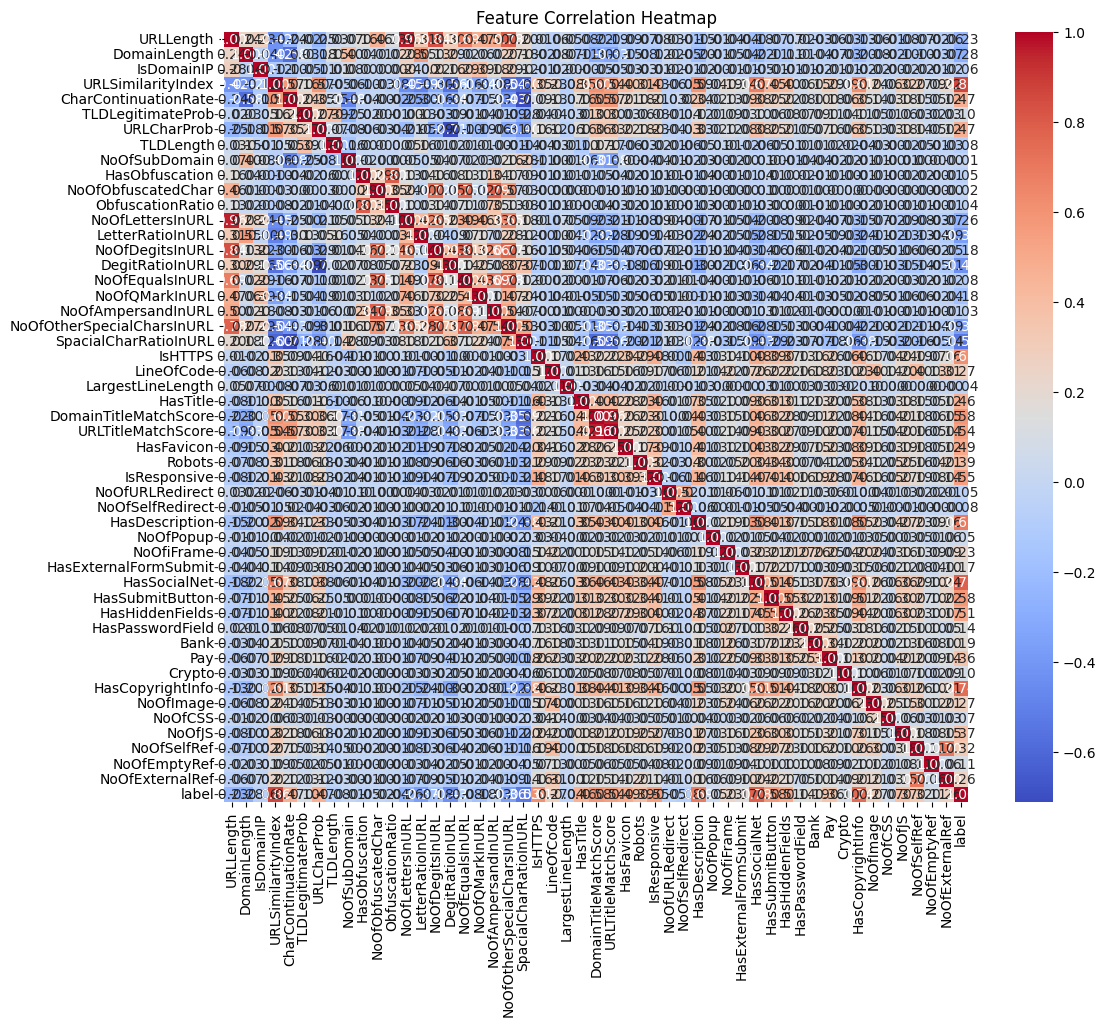

In [11]:
# Compute correlation matrix
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation = numeric_df.corr()

# Plot heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()



In [12]:
# Check correlation of all features with the target
correlation_with_target = numeric_df.corr()['label'].sort_values(ascending=False)
print("Correlation with Target Variable:")
print(correlation_with_target)
suitable_columns = correlation_with_target[abs(correlation_with_target) < 0.2].index.tolist()


Correlation with Target Variable:
label                         1.000000
URLSimilarityIndex            0.860358
HasSocialNet                  0.784255
HasCopyrightInfo              0.743358
HasDescription                0.690232
IsHTTPS                       0.609132
DomainTitleMatchScore         0.584905
HasSubmitButton               0.578561
IsResponsive                  0.548608
URLTitleMatchScore            0.539419
HasHiddenFields               0.507731
HasFavicon                    0.493711
URLCharProb                   0.469749
CharContinuationRate          0.467735
HasTitle                      0.459725
Robots                        0.392620
NoOfJS                        0.373500
Pay                           0.359747
NoOfSelfRef                   0.316211
NoOfImage                     0.274658
LineOfCode                    0.272257
NoOfExternalRef               0.258627
NoOfiFrame                    0.225822
Bank                          0.188959
HasExternalFormSubmit         

In [13]:
suitable_columns = correlation_with_target[abs(correlation_with_target) < 0.2].index.tolist()

In [14]:
suitable_columns

['Bank',
 'HasExternalFormSubmit',
 'HasPasswordField',
 'NoOfEmptyRef',
 'Crypto',
 'TLDLegitimateProb',
 'NoOfCSS',
 'NoOfPopup',
 'NoOfSubDomain',
 'NoOfObfuscatedChar',
 'NoOfAmpersandInURL',
 'LargestLineLength',
 'ObfuscationRatio',
 'NoOfURLRedirect',
 'HasObfuscation',
 'IsDomainIP',
 'NoOfSelfRedirect',
 'NoOfEqualsInURL',
 'TLDLength',
 'NoOfQMarkInURL',
 'NoOfDegitsInURL']

In [15]:
# class distribution

df['label'].value_counts()

,count
label,
1,134850
0,100945


In [16]:
class1_counts=(df['label'].value_counts()[1])
class1_counts

134850

In [17]:
class2_counts=(df['label'].value_counts()[0])
class2_counts

100945

In [18]:
cls_diff=class1_counts-class2_counts
cls_diff

33905

In [19]:
class1_counts-cls_diff

100945

In [20]:
class1_counts=(df['label'].value_counts()[1])
class2_counts=(df['label'].value_counts()[0])
cls_diff=class1_counts-class2_counts
sf_df = shuffle(df, random_state=42)
sf_df2 = shuffle(df_withURL, random_state=42)

In [21]:
sf_df2

,URL,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
136221,https://www.northcm.ac.th,24,17,0,100.000000,0.800000,0.000510,0.064490,2,2,...,0,0,1,47,3,4,69,7,115,1
56609,https://unitedmartialartscenters.com/at0/mygov...,59,28,0,33.522664,1.000000,0.522907,0.060027,3,0,...,1,0,1,0,2,0,0,0,1,0
46393,https://email.mail1.onesignal.os.tc/c/ejwcz02u...,385,27,0,3.199329,0.458333,0.000046,0.034325,2,3,...,0,0,0,0,0,0,0,0,1,0
129746,http://uqr.to/1il1z,19,6,0,53.846154,1.000000,0.000896,0.036850,2,0,...,0,0,0,0,0,0,1,0,1,0
131464,https://www.woolworthsrewards.com.au,35,28,0,100.000000,0.857143,0.010086,0.060894,2,2,...,1,0,1,33,7,8,15,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,https://www.greenmountainenergy.com,34,27,0,100.000000,1.000000,0.522907,0.064465,3,1,...,1,0,1,26,6,16,169,15,40,1
103694,https://www.leadcastingcall.com,30,23,0,100.000000,1.000000,0.522907,0.063148,3,1,...,0,0,1,25,9,22,87,1,93,1
131932,https://aruba.serveice-mein-auth.com/kqtxa8j9v...,114,28,0,11.574038,0.375000,0.522907,0.038615,3,1,...,0,0,0,0,0,0,0,0,0,0
146867,https://www.fedarb.com,21,14,0,100.000000,1.000000,0.522907,0.059510,3,1,...,0,0,1,24,36,48,102,1,50,1


In [22]:
drop_indices = sf_df[sf_df['label'] == 1].sample(n=cls_diff).index
# Drop those rows
bal_df = sf_df.drop(drop_indices)

df_withURL= sf_df2.drop(drop_indices)

In [23]:
df_withURL['label'].value_counts()

,count
label,
1,100945
0,100945


In [24]:
bal_df['label'].value_counts()

,count
label,
1,100945
0,100945


<ipython-input-25-a2f19f1934a1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


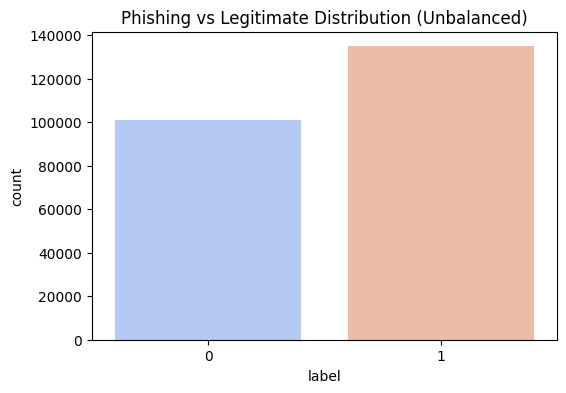

In [25]:

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Phishing vs Legitimate Distribution (Unbalanced)")
plt.show()

<ipython-input-26-f604ba4f95e2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=bal_df, palette='coolwarm')


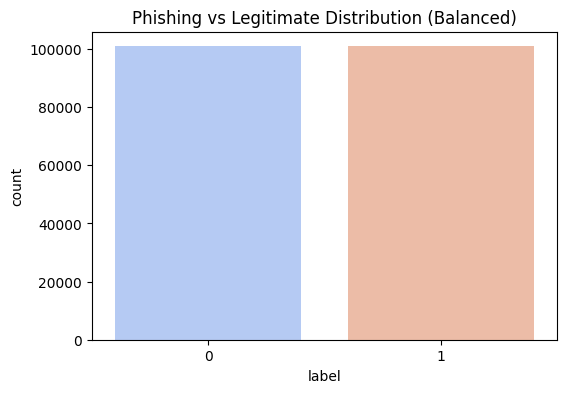

In [26]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=bal_df, palette='coolwarm')
plt.title("Phishing vs Legitimate Distribution (Balanced)")
plt.show()

In [27]:
y= bal_df['label']

In [28]:
y

,label
136221,1
56609,0
46393,0
129746,0
131464,1
...,...
54886,0
207892,0
110268,1
103694,1


In [29]:
df_withURL

,URL,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
136221,https://www.northcm.ac.th,24,17,0,100.000000,0.800000,0.000510,0.064490,2,2,...,0,0,1,47,3,4,69,7,115,1
56609,https://unitedmartialartscenters.com/at0/mygov...,59,28,0,33.522664,1.000000,0.522907,0.060027,3,0,...,1,0,1,0,2,0,0,0,1,0
46393,https://email.mail1.onesignal.os.tc/c/ejwcz02u...,385,27,0,3.199329,0.458333,0.000046,0.034325,2,3,...,0,0,0,0,0,0,0,0,1,0
129746,http://uqr.to/1il1z,19,6,0,53.846154,1.000000,0.000896,0.036850,2,0,...,0,0,0,0,0,0,1,0,1,0
131464,https://www.woolworthsrewards.com.au,35,28,0,100.000000,0.857143,0.010086,0.060894,2,2,...,1,0,1,33,7,8,15,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54886,http://www.ota-relay.com,23,17,0,69.230769,0.666667,0.522907,0.070378,3,1,...,0,0,0,0,0,0,0,0,0,0
207892,https://kjdhguh.dfhruty.repl.co/,32,23,0,34.593573,0.400000,0.005977,0.039281,2,2,...,0,0,0,0,0,0,0,0,2,0
110268,https://www.slavevoyages.org,27,20,0,100.000000,1.000000,0.079963,0.059055,3,1,...,0,0,1,23,3,6,71,12,28,1
103694,https://www.leadcastingcall.com,30,23,0,100.000000,1.000000,0.522907,0.063148,3,1,...,0,0,1,25,9,22,87,1,93,1


In [30]:
X=bal_df[suitable_columns]

In [31]:
X_url= X.copy()
X_url['URL']=df_withURL['URL']

In [32]:
X_url

,Bank,HasExternalFormSubmit,HasPasswordField,NoOfEmptyRef,Crypto,TLDLegitimateProb,NoOfCSS,NoOfPopup,NoOfSubDomain,NoOfObfuscatedChar,...,ObfuscationRatio,NoOfURLRedirect,HasObfuscation,IsDomainIP,NoOfSelfRedirect,NoOfEqualsInURL,TLDLength,NoOfQMarkInURL,NoOfDegitsInURL,URL
136221,0,0,0,7,0,0.000510,3,0,2,0,...,0.0,0,0,0,0,0,2,0,0,https://www.northcm.ac.th
56609,1,0,0,0,0,0.522907,2,0,0,0,...,0.0,0,0,0,0,0,3,0,1,https://unitedmartialartscenters.com/at0/mygov...
46393,0,0,0,0,0,0.000046,0,0,3,0,...,0.0,0,0,0,0,0,2,0,51,https://email.mail1.onesignal.os.tc/c/ejwcz02u...
129746,0,0,0,0,0,0.000896,0,0,0,0,...,0.0,0,0,0,0,0,2,0,2,http://uqr.to/1il1z
131464,1,0,1,0,0,0.010086,7,0,2,0,...,0.0,1,0,0,1,0,2,0,0,https://www.woolworthsrewards.com.au
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54886,0,0,0,0,0,0.522907,0,0,1,0,...,0.0,0,0,0,0,0,3,0,0,http://www.ota-relay.com
207892,0,0,0,0,0,0.005977,0,0,2,0,...,0.0,0,0,0,0,0,2,0,0,https://kjdhguh.dfhruty.repl.co/
110268,0,0,0,12,0,0.079963,3,0,1,0,...,0.0,0,0,0,0,0,3,0,0,https://www.slavevoyages.org
103694,0,0,0,1,0,0.522907,9,1,1,0,...,0.0,0,0,0,0,0,3,0,0,https://www.leadcastingcall.com


In [33]:
 X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.1,
        random_state=42,
        stratify=y
    )

In [34]:
X_train

,Bank,HasExternalFormSubmit,HasPasswordField,NoOfEmptyRef,Crypto,TLDLegitimateProb,NoOfCSS,NoOfPopup,NoOfSubDomain,NoOfObfuscatedChar,...,LargestLineLength,ObfuscationRatio,NoOfURLRedirect,HasObfuscation,IsDomainIP,NoOfSelfRedirect,NoOfEqualsInURL,TLDLength,NoOfQMarkInURL,NoOfDegitsInURL
51769,0,0,0,0,0,0.000226,0,0,1,0,...,209,0.0,1,0,0,1,0,2,0,0
13097,1,0,1,26,0,0.522907,10,0,1,0,...,9458,0.0,0,0,0,0,0,3,0,0
63321,0,0,0,0,0,0.079963,0,0,1,0,...,1034,0.0,0,0,0,0,0,3,0,0
226658,0,0,1,4,0,0.522907,5,0,1,0,...,387,0.0,0,0,0,0,0,3,0,0
33379,0,0,0,0,1,0.522907,6,0,1,0,...,1952,0.0,0,0,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94137,0,0,0,0,0,0.006970,0,0,2,0,...,35,0.0,0,0,0,0,0,2,0,0
133360,0,0,1,14,0,0.522907,10,0,1,0,...,9381,0.0,0,0,0,0,0,3,0,0
177757,0,0,0,0,0,0.522907,0,0,1,0,...,100,0.0,1,0,0,0,0,3,0,0
14144,0,0,0,5,0,0.522907,26,0,1,0,...,8047,0.0,0,0,0,0,0,3,0,0


In [35]:
def evaluate_model(name, y_test, y_pred, y_prob=None):
    """
    Evaluate model performance with visualizations
    """
    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC curve if probabilities are available
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple models including LinearSVC
    """
    # Initialize base LinearSVC
    base_svm = LinearSVC(random_state=42)
    # Wrap it with CalibratedClassifierCV to get probability estimates
    svm = CalibratedClassifierCV(base_svm, cv=5)

    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42),
        'Linear SVM': svm
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Get probabilities (all models now support predict_proba)
        y_prob = model.predict_proba(X_test)[:, 1]

        evaluate_model(name, y_test, y_pred, y_prob)

        results[name] = {
            'model': model,
            'predictions': y_pred,
            'probabilities': y_prob
        }

    return results

In [36]:
X_train

,Bank,HasExternalFormSubmit,HasPasswordField,NoOfEmptyRef,Crypto,TLDLegitimateProb,NoOfCSS,NoOfPopup,NoOfSubDomain,NoOfObfuscatedChar,...,LargestLineLength,ObfuscationRatio,NoOfURLRedirect,HasObfuscation,IsDomainIP,NoOfSelfRedirect,NoOfEqualsInURL,TLDLength,NoOfQMarkInURL,NoOfDegitsInURL
51769,0,0,0,0,0,0.000226,0,0,1,0,...,209,0.0,1,0,0,1,0,2,0,0
13097,1,0,1,26,0,0.522907,10,0,1,0,...,9458,0.0,0,0,0,0,0,3,0,0
63321,0,0,0,0,0,0.079963,0,0,1,0,...,1034,0.0,0,0,0,0,0,3,0,0
226658,0,0,1,4,0,0.522907,5,0,1,0,...,387,0.0,0,0,0,0,0,3,0,0
33379,0,0,0,0,1,0.522907,6,0,1,0,...,1952,0.0,0,0,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94137,0,0,0,0,0,0.006970,0,0,2,0,...,35,0.0,0,0,0,0,0,2,0,0
133360,0,0,1,14,0,0.522907,10,0,1,0,...,9381,0.0,0,0,0,0,0,3,0,0
177757,0,0,0,0,0,0.522907,0,0,1,0,...,100,0.0,1,0,0,0,0,3,0,0
14144,0,0,0,5,0,0.522907,26,0,1,0,...,8047,0.0,0,0,0,0,0,3,0,0


In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training and evaluating models...

Training Decision Tree...

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10095
           1       0.99      0.98      0.98     10094

    accuracy                           0.98     20189
   macro avg       0.98      0.98      0.98     20189
weighted avg       0.98      0.98      0.98     20189



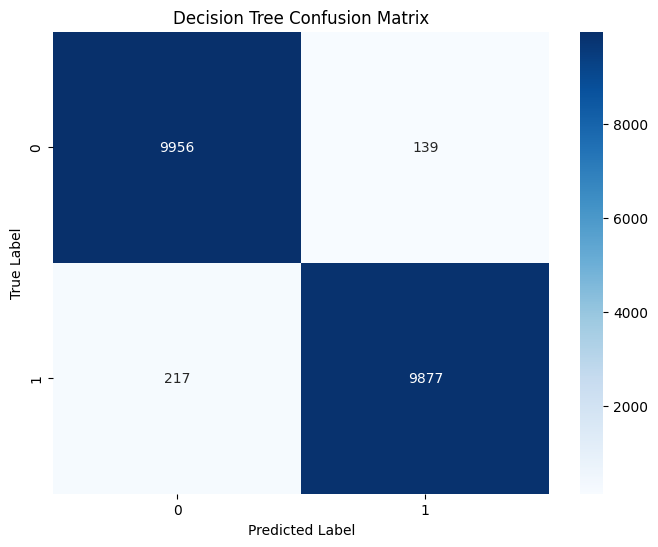

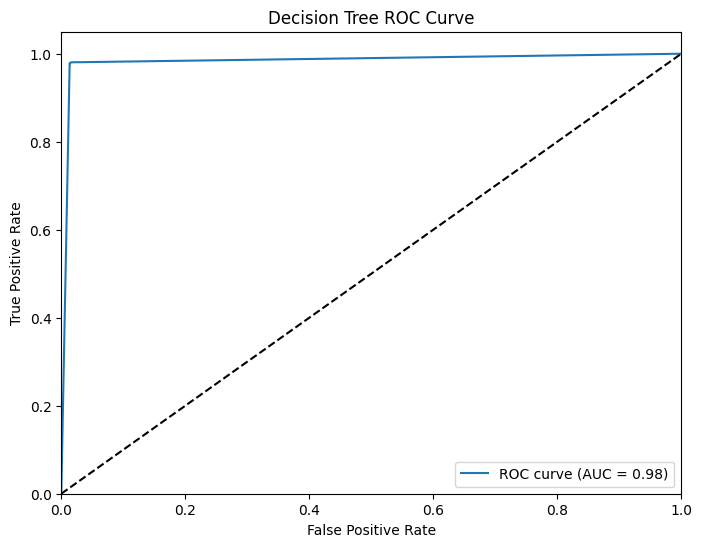


Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10095
           1       0.99      0.98      0.99     10094

    accuracy                           0.99     20189
   macro avg       0.99      0.99      0.99     20189
weighted avg       0.99      0.99      0.99     20189



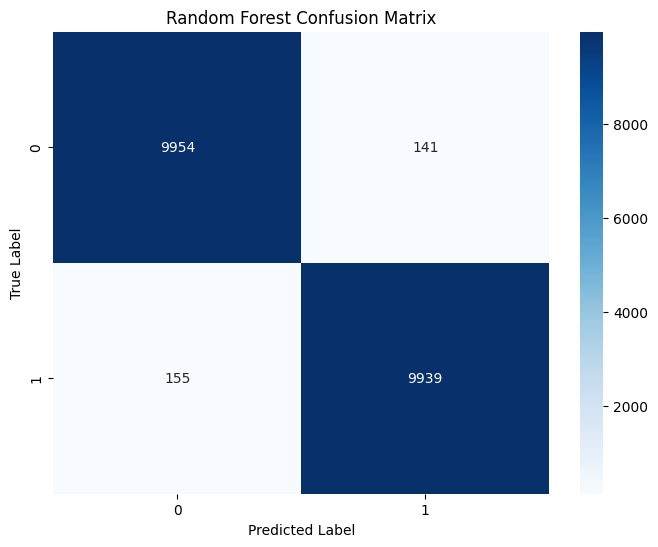

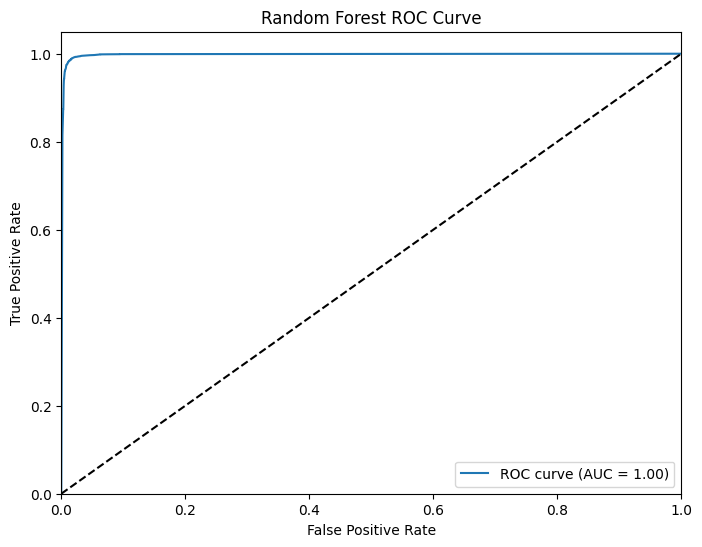


Training XGBoost...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10095
           1       0.98      0.99      0.99     10094

    accuracy                           0.98     20189
   macro avg       0.99      0.98      0.98     20189
weighted avg       0.99      0.98      0.98     20189



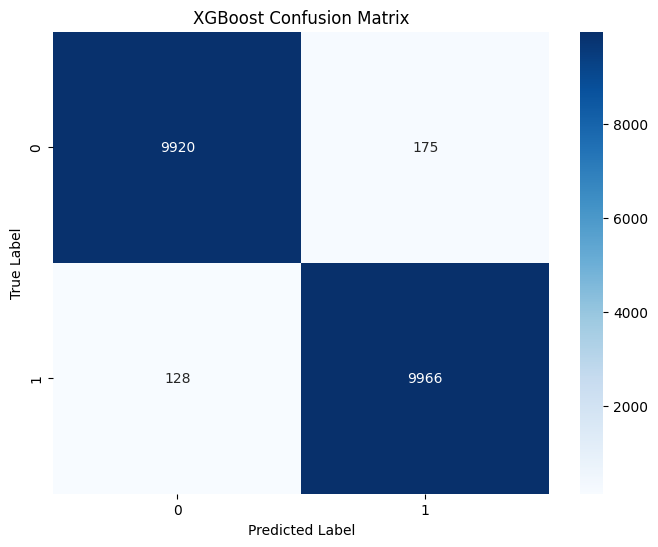

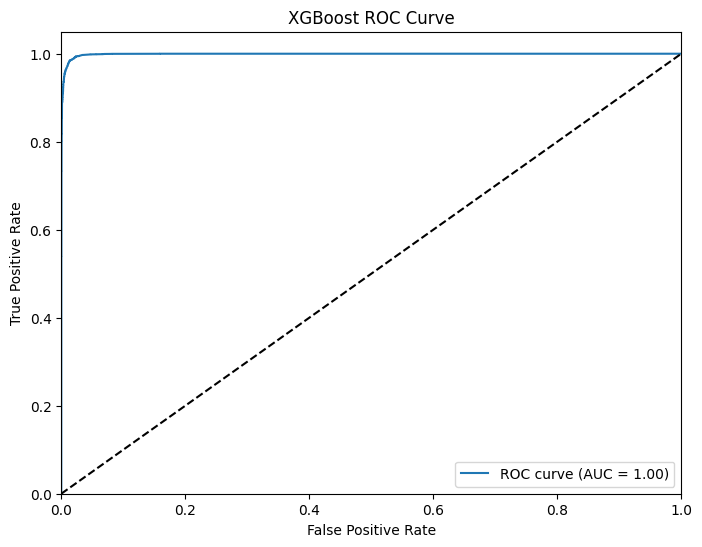


Training Linear SVM...

Linear SVM Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10095
           1       0.96      0.92      0.94     10094

    accuracy                           0.94     20189
   macro avg       0.94      0.94      0.94     20189
weighted avg       0.94      0.94      0.94     20189



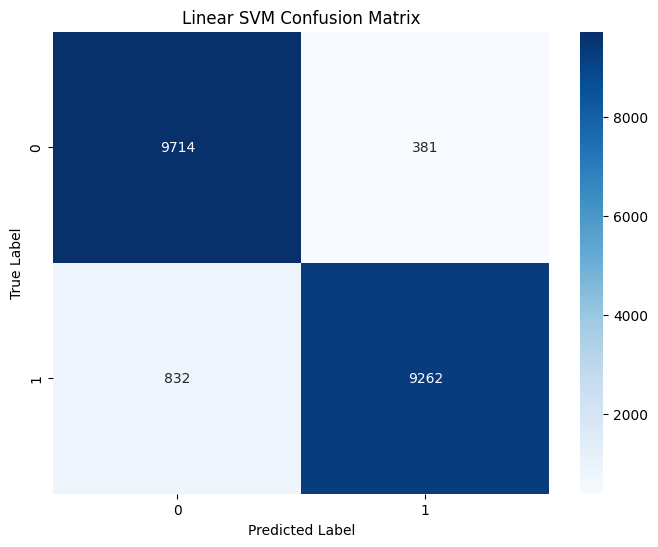

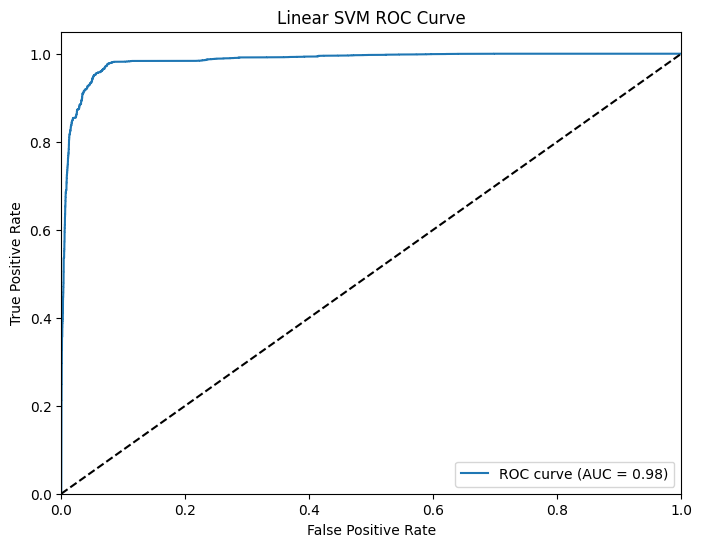


Step 7: Comparing model performances...


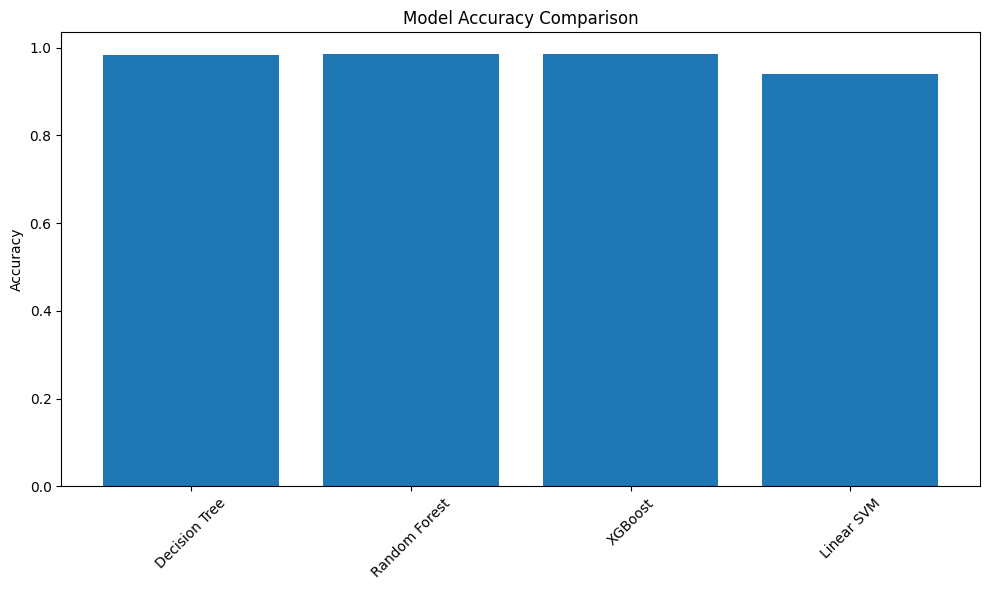

In [38]:
print("\nTraining and evaluating models...")
results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

# 7. Compare model performances
print("\nStep 7: Comparing model performances...")
model_scores = {}
for name, result in results.items():
  model_scores[name] = classification_report(y_test, result['predictions'], output_dict=True)['accuracy']

plt.figure(figsize=(10, 6))
plt.bar(model_scores.keys(), model_scores.values())
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **ADVANCED MODELLING AND EVALUATION WITH CROSS VALIDATION**

In [39]:

def compare_models(cv_results_dict):
    """
    Compare all models and create visualization
    """
    # Prepare data for comparison
    metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    comparison_data = []

    for model_name, cv_results in cv_results_dict.items():
        model_metrics = {}
        model_metrics['Model'] = model_name
        for metric in metrics:
            scores = cv_results[f'test_{metric}']
            model_metrics[metric] = scores.mean()
            model_metrics[f'{metric}_std'] = scores.std()
        comparison_data.append(model_metrics)

    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)

    # Display table
    print("\nModel Comparison Table:")
    comparison_table = comparison_df.copy()
    for metric in metrics:
        comparison_table[metric] = comparison_table.apply(
            lambda x: f"{x[metric]:.3f} ± {x[f'{metric}_std']:.3f}",
            axis=1
        )
    print(comparison_table[['Model'] + metrics].to_string(index=False))

    # Create bar plot
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics))
    width = 0.2

    for i, model_name in enumerate(cv_results_dict.keys()):
        values = [comparison_df[comparison_df['Model'] == model_name][metric].values[0]
                 for metric in metrics]
        plt.bar(x + i*width, values, width, label=model_name)

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Comparison')
    plt.xticks(x + width*1.5, metrics)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return comparison_df

def save_best_model(models, cv_results_dict, save_dir='/content/drive/My Drive/url_phising_prj/models'):
    """
    Save the best performing model based on F1 score
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Find best model
    best_f1 = -1
    best_model_name = None

    for model_name, cv_results in cv_results_dict.items():
        f1_score = cv_results['test_f1_weighted'].mean()
        if f1_score > best_f1:
            best_f1 = f1_score
            best_model_name = model_name

    # Save best model
    best_model = models[best_model_name]
    model_path = os.path.join(save_dir, f'best_model_{best_model_name}.joblib')
    joblib.dump(best_model, model_path)

    print(f"\nBest Model: {best_model_name}")
    print(f"F1 Score: {best_f1:.3f}")
    print(f"Model saved to: {model_path}")

    return best_model_name, model_path

def manual_xgboost_cv(X, y, cv=5):
    """
    Manual cross-validation for XGBoost to avoid scikit-learn compatibility issues
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Initialize arrays to store metrics
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    model = xgb.XGBClassifier(
        random_state=42,
        objective='binary:logistic'
    )

    # Perform manual cross-validation
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='weighted'))
        recalls.append(recall_score(y_test, y_pred, average='weighted'))
        f1s.append(f1_score(y_test, y_pred, average='weighted'))

    # Create cv_results dict in sklearn format
    cv_results = {
        'test_accuracy': np.array(accuracies),
        'test_precision_weighted': np.array(precisions),
        'test_recall_weighted': np.array(recalls),
        'test_f1_weighted': np.array(f1s)
    }

    # Fit on full dataset
    model.fit(X, y)

    return model, cv_results

def plot_feature_importance(model, feature_names, title):
    """
    Plot feature importance for tree-based models
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(range(len(importances)), importances[indices])
        plt.title(f"Feature Importances ({title})")

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')

        plt.xticks(range(len(importances)),
                   [feature_names[i] for i in indices],
                   rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

def plot_learning_curves(model, X, y, title, cv=5):
    """
    Plot learning curves to show model performance
    """
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
    plt.title(f'{title} Learning Curves')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def plot_cross_val_results(cv_results, model_name):
    """
    Plot cross-validation results
    """
    metrics = ['test_accuracy', 'test_precision_weighted',
              'test_recall_weighted', 'test_f1_weighted']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Boxplot
    box_data = [cv_results[metric] for metric in metrics]
    ax1.boxplot(box_data, labels=[m.replace('test_', '').replace('_weighted', '')
                                 for m in metrics])
    ax1.set_title(f'{model_name} Cross-Validation Metrics')
    ax1.tick_params(axis='x', rotation=45)

    # Violin plot
    violin_data = pd.DataFrame({metric.replace('test_', '').replace('_weighted', ''):
                              cv_results[metric] for metric in metrics})
    sns.violinplot(data=violin_data, ax=ax2)
    ax2.set_title(f'{model_name} Metrics Distribution')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def optimize_svm(X, y, cv=5):
    """
    Optimize SVM for better performance
    """
    print("Optimizing SVM...")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    n_components = min(X.shape[1], 100)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    linear_svc = LinearSVC(random_state=42, max_iter=2000)
    linear_scores = cross_validate(linear_svc, X_pca, y, cv=cv,
                                 scoring='accuracy', n_jobs=-1)

    if np.mean(linear_scores['test_score']) > 0.8:
        print("Using LinearSVC")
        return LinearSVC(random_state=42, max_iter=2000)

    print("Using regular SVC with optimization...")
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear']
    }

    svc = SVC(random_state=42, probability=True)
    grid_search = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_pca, y)

    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

# def evaluate_model_cv(name, model, X, y, feature_names, cv=5):
#     """
#     Enhanced model evaluation with additional metrics
#     """
#     print(f"\nEvaluating {name} with {cv}-fold cross-validation...")

#     start_time = time.time()

#     if name == 'XGBoost':
#         model, cv_results = manual_xgboost_cv(X, y, cv)
#     elif name == 'SVM':
#         model = optimize_svm(X, y, cv)
#         scoring = {
#             'accuracy': 'accuracy',
#             'precision_weighted': 'precision_weighted',
#             'recall_weighted': 'recall_weighted',
#             'f1_weighted': 'f1_weighted'
#         }
#         cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
#     else:
#         scoring = {
#             'accuracy': 'accuracy',
#             'precision_weighted': 'precision_weighted',
#             'recall_weighted': 'recall_weighted',
#             'f1_weighted': 'f1_weighted'
#         }
#         cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

#     end_time = time.time()
#     print(f"\nTime taken: {end_time - start_time:.2f} seconds")

#     print("\nCross-validation metrics:")
#     for metric, scores in cv_results.items():
#         if metric.startswith('test_'):
#             print(f"{metric.replace('test_', '')}: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

#     # Fit model on full dataset for final evaluation
#     model.fit(X, y)

#     # Get classification report and confusion matrix
#     # get_classification_metrics(model, X, y, name)

#     plot_cross_val_results(cv_results, name)

#     if name != 'XGBoost':
#         plot_learning_curves(model, X, y, name, cv)

#     if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
#         plot_feature_importance(model, feature_names, name)

#     return model, cv_results

# def train_and_evaluate_models_cv(X, y, feature_names, save_dir='models'):
#     """
#     Enhanced training and evaluation with model comparison and saving
#     """
#     models = {
#         'Decision Tree': DecisionTreeClassifier(random_state=42),
#         'Random Forest': RandomForestClassifier(random_state=42),
#         'XGBoost': None,
#         'SVM': None
#     }

#     results = {}
#     cv_results = {}

#     for name, model in tqdm(models.items(), desc="Training models"):
#         model, cv_result = evaluate_model_cv(name, model, X, y, feature_names)
#         results[name] = model
#         cv_results[name] = cv_result

#     # Compare all models
#     print("\nModel Comparison:")
#     comparison_df = compare_models(cv_results)

#     # Save best model
#     best_model_name, model_path = save_best_model(results, cv_results, save_dir)

#     return results, cv_results, comparison_df, best_model_name, model_path

In [40]:
def create_fold_comparison_table(cv_results_dict, n_folds=10):
    """
    Create a detailed table showing performance metrics for each fold of each model
    """
    import pandas as pd
    import numpy as np

    metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    rows = []

    for model_name, cv_results in cv_results_dict.items():
        for fold in range(n_folds):
            row = {'Model': model_name, 'Fold': fold + 1}
            for metric in metrics:
                row[metric] = cv_results[f'test_{metric}'][fold]
            rows.append(row)

    # Create detailed fold-by-fold DataFrame
    fold_df = pd.DataFrame(rows)

    # Create summary statistics
    summary_stats = []
    for model_name, cv_results in cv_results_dict.items():
        stats = {'Model': model_name}
        for metric in metrics:
            values = cv_results[f'test_{metric}']
            stats[f'{metric}_mean'] = values.mean()
            stats[f'{metric}_std'] = values.std()
        summary_stats.append(stats)

    summary_df = pd.DataFrame(summary_stats)

    return fold_df, summary_df

def display_fold_results(fold_df, summary_df):
    """
    Display formatted fold-by-fold results and summary statistics
    """
    # Display fold-by-fold results
    print("\nDetailed Fold-by-Fold Performance:")
    print(fold_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

    # Display summary with formatted mean ± std
    print("\nOverall Model Performance (mean ± std):")
    metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    display_df = summary_df[['Model']].copy()

    for metric in metrics:
        display_df[metric] = summary_df.apply(
            lambda x: f"{x[f'{metric}_mean']:.3f} ± {x[f'{metric}_std']:.3f}",
            axis=1
        )

    print(display_df.to_string(index=False))

def plot_fold_performance(fold_df):
    """
    Create visualizations for fold-by-fold performance
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

    # Create a figure with subplots for each metric
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Across Folds', fontsize=16)

    for idx, (metric, ax) in enumerate(zip(metrics, axes.flat)):
        sns.boxplot(data=fold_df, x='Model', y=metric, ax=ax)
        ax.set_title(f'{metric.replace("_weighted", "").title()}')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Create line plot showing trends across folds
    plt.figure(figsize=(15, 8))
    for metric in metrics:
        plt.subplot(2, 2, metrics.index(metric) + 1)
        for model in fold_df['Model'].unique():
            model_data = fold_df[fold_df['Model'] == model]
            plt.plot(model_data['Fold'], model_data[metric], marker='o', label=model)
        plt.title(f'{metric.replace("_weighted", "").title()} Across Folds')
        plt.xlabel('Fold')
        plt.ylabel('Score')
        plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model_cv(name, model, X, y, feature_names, cv=10):  #  10 folds
    """
    Modified evaluation function to use 10 folds
    """
    print(f"\nEvaluating {name} with {cv}-fold cross-validation...")

    start_time = time.time()

    if name == 'XGBoost':
        model, cv_results = manual_xgboost_cv(X, y, cv)
    elif name == 'SVM':
        model = optimize_svm(X, y, cv)
        scoring = {
            'accuracy': 'accuracy',
            'precision_weighted': 'precision_weighted',
            'recall_weighted': 'recall_weighted',
            'f1_weighted': 'f1_weighted'
        }
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    else:
        scoring = {
            'accuracy': 'accuracy',
            'precision_weighted': 'precision_weighted',
            'recall_weighted': 'recall_weighted',
            'f1_weighted': 'f1_weighted'
        }
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

    end_time = time.time()
    print(f"\nTime taken: {end_time - start_time:.2f} seconds")

    if name != 'XGBoost':
        plot_learning_curves(model, X, y, name, cv)

    if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        plot_feature_importance(model, feature_names, name)

    return model, cv_results

def train_and_evaluate_models_cv(X, y, feature_names, save_dir='/content/drive/My Drive/url_phising_prj/models'):
    """
    Modified training and evaluation function to include fold-by-fold analysis
    """
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': None,
        'SVM': None
    }

    results = {}
    cv_results = {}

    for name, model in tqdm(models.items(), desc="Training models"):
        model, cv_result = evaluate_model_cv(name, model, X, y, feature_names)
        results[name] = model
        cv_results[name] = cv_result

    # Create and display fold-by-fold comparison
    fold_df, summary_df = create_fold_comparison_table(cv_results)
    display_fold_results(fold_df, summary_df)
    plot_fold_performance(fold_df)

    # Save best model
    best_model_name, model_path = save_best_model(results, cv_results, save_dir)

    return results, cv_results, fold_df, summary_df, best_model_name, model_path

Training models:   0%|          | 0/4 [00:00<?, ?it/s]


Evaluating Decision Tree with 10-fold cross-validation...

Time taken: 7.97 seconds


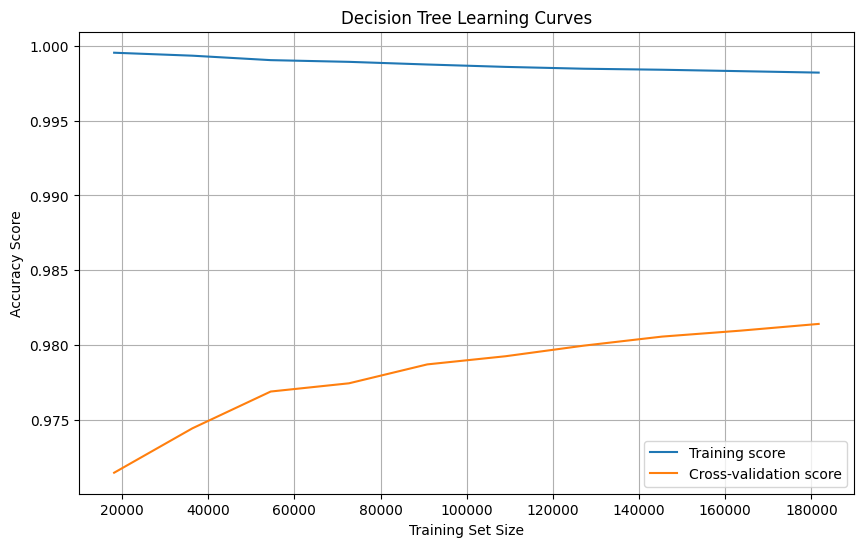

Training models:  25%|██▌       | 1/4 [00:38<01:56, 38.73s/it]


Evaluating Random Forest with 10-fold cross-validation...

Time taken: 150.03 seconds


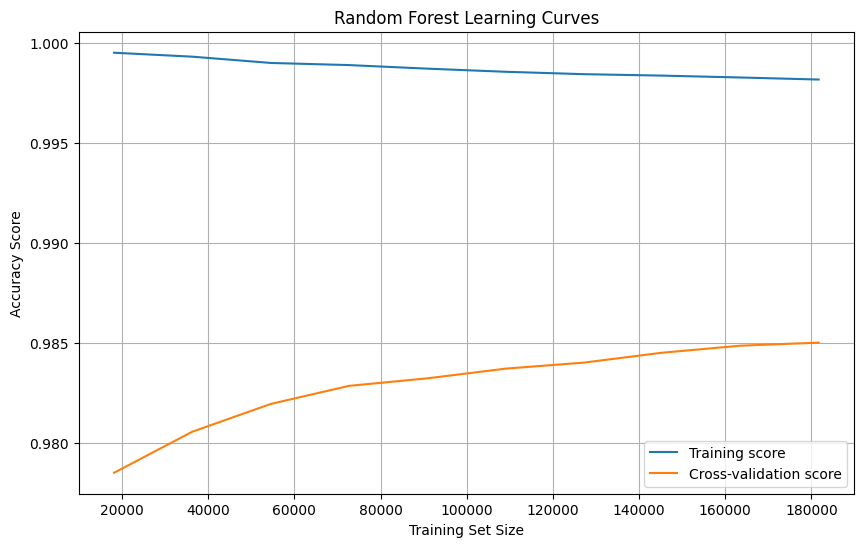

Training models:  50%|█████     | 2/4 [13:29<15:38, 469.21s/it]


Evaluating XGBoost with 10-fold cross-validation...

Time taken: 16.61 seconds


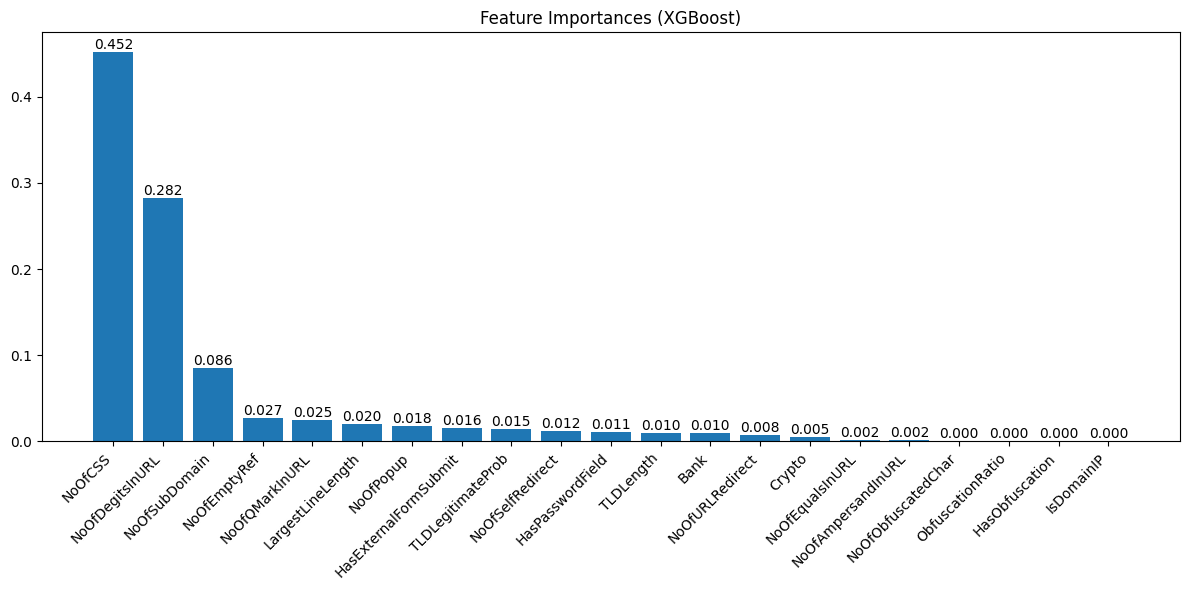

Training models:  75%|███████▌  | 3/4 [13:46<04:22, 262.65s/it]


Evaluating SVM with 10-fold cross-validation...
Optimizing SVM...
Using LinearSVC

Time taken: 38.75 seconds


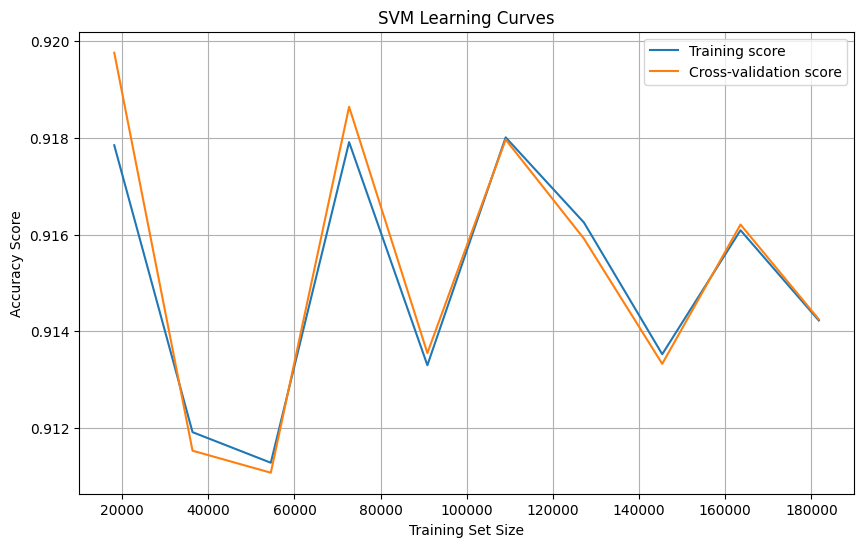

Training models: 100%|██████████| 4/4 [14:46<00:00, 221.69s/it]



Detailed Fold-by-Fold Performance:
        Model  Fold  accuracy  precision_weighted  recall_weighted  f1_weighted
Decision Tree     1     0.982               0.982            0.982        0.982
Decision Tree     2     0.982               0.982            0.982        0.982
Decision Tree     3     0.980               0.980            0.980        0.980
Decision Tree     4     0.980               0.980            0.980        0.980
Decision Tree     5     0.981               0.981            0.981        0.981
Decision Tree     6     0.983               0.983            0.983        0.983
Decision Tree     7     0.982               0.982            0.982        0.982
Decision Tree     8     0.983               0.983            0.983        0.983
Decision Tree     9     0.980               0.980            0.980        0.980
Decision Tree    10     0.981               0.981            0.981        0.981
Random Forest     1     0.984               0.984            0.984        0.984
Rand

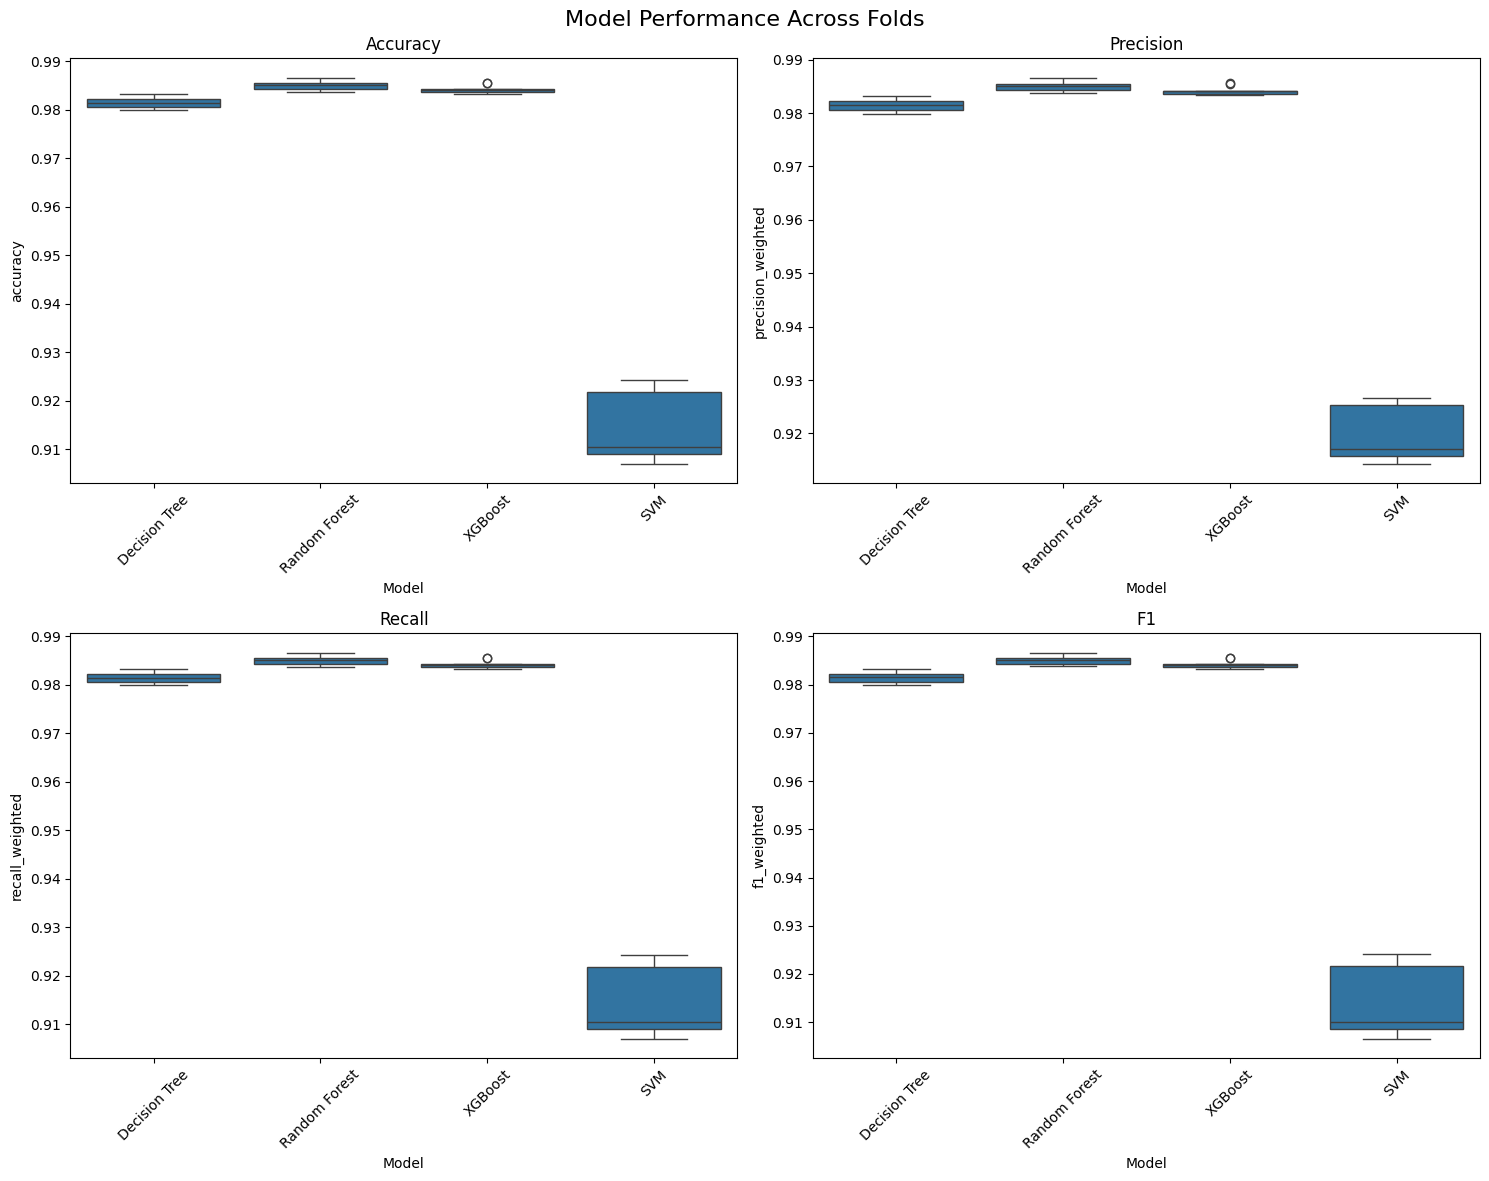

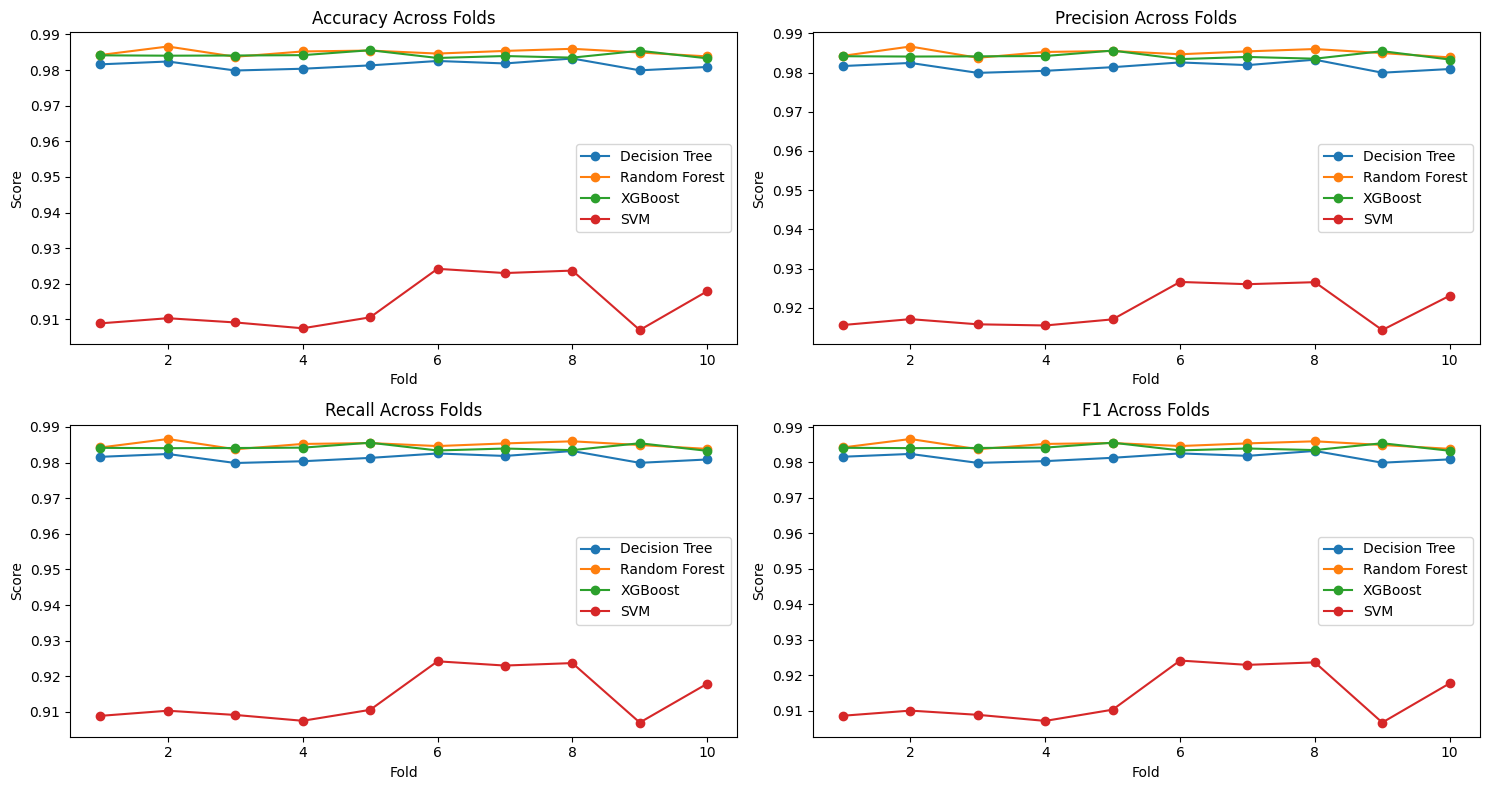


Best Model: Random Forest
F1 Score: 0.985
Model saved to: /content/drive/My Drive/url_phising_prj/models/best_model_Random Forest.joblib


In [41]:
# Train and evaluate models
feature_names = X.columns

results, cv_results, fold_df, summary_df, best_model_name, model_path = train_and_evaluate_models_cv(X, y, feature_names)


In [42]:
model_path

'/content/drive/My Drive/url_phising_prj/models/best_model_Random Forest.joblib'

In [43]:
def evaluate_model_cv(name, model, X, y, feature_names, cv=10):
    """
    Modified evaluation function to use 10 folds and ensure learning curves for all models
    """
    print(f"\nEvaluating {name} with {cv}-fold cross-validation...")

    start_time = time.time()

    # Initialize the model if it's XGBoost
    if name == 'XGBoost':
        import xgboost as xgb
        if model is None:
            model = xgb.XGBClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                random_state=42
            )

    # Handle SVM initialization
    elif name == 'SVM':
        if model is None:
            model = optimize_svm(X, y, cv)

    # Perform cross-validation
    scoring = {
        'accuracy': 'accuracy',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted',
        'f1_weighted': 'f1_weighted'
    }
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

    end_time = time.time()
    print(f"\nTime taken: {end_time - start_time:.2f} seconds")

    # Plot learning curves for all models
    plot_learning_curves(model, X, y, name, cv)

    # Plot feature importance for tree-based models
    if name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        plot_feature_importance(model, feature_names, name)

    return model, cv_results

def plot_learning_curves(model, X, y, model_name, cv):
    """
    Enhanced learning curve plotting function that handles all model types
    """
    from sklearn.model_selection import learning_curve
    import numpy as np
    import matplotlib.pyplot as plt

    # Define training sizes
    train_sizes = np.linspace(0.1, 1.0, 10)

    # Calculate learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, val_mean, label='Cross-validation score', color='red', marker='o')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')

    plt.title(f'Learning Curves - {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def train_and_evaluate_models_cv(X, y, feature_names, save_dir='models'):
    """
    Modified training and evaluation function with unified model handling
    """
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    import xgboost as xgb
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42),
        'SVM': None  # Will be initialized in evaluate_model_cv
    }
    results = {}
    cv_results = {}

    for name, model in tqdm(models.items(), desc="Training models"):
        model, cv_result = evaluate_model_cv(name, model, X, y, feature_names)
        results[name] = model
        cv_results[name] = cv_result

    # Create and display fold-by-fold comparison
    fold_df, summary_df = create_fold_comparison_table(cv_results)
    display_fold_results(fold_df, summary_df)
    plot_fold_performance(fold_df)

    # Save best model
    best_model_name, model_path = save_best_model(results, cv_results, save_dir)

    return results, cv_results, fold_df, summary_df, best_model_name, model_path

In [44]:
feature_names = X.columns


Training models:   0%|          | 0/4 [00:00<?, ?it/s]


Evaluating Decision Tree with 10-fold cross-validation...

Time taken: 7.34 seconds


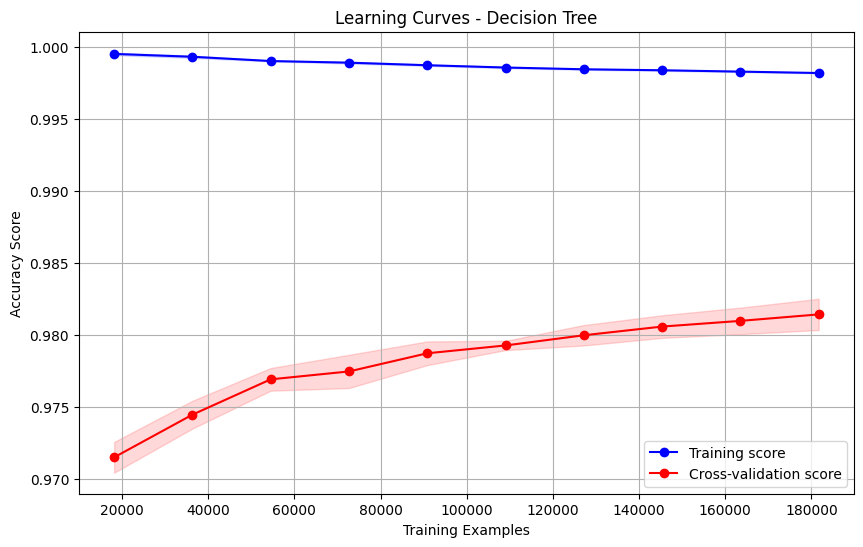

Training models:  25%|██▌       | 1/4 [00:37<01:53, 38.00s/it]


Evaluating Random Forest with 10-fold cross-validation...

Time taken: 145.56 seconds


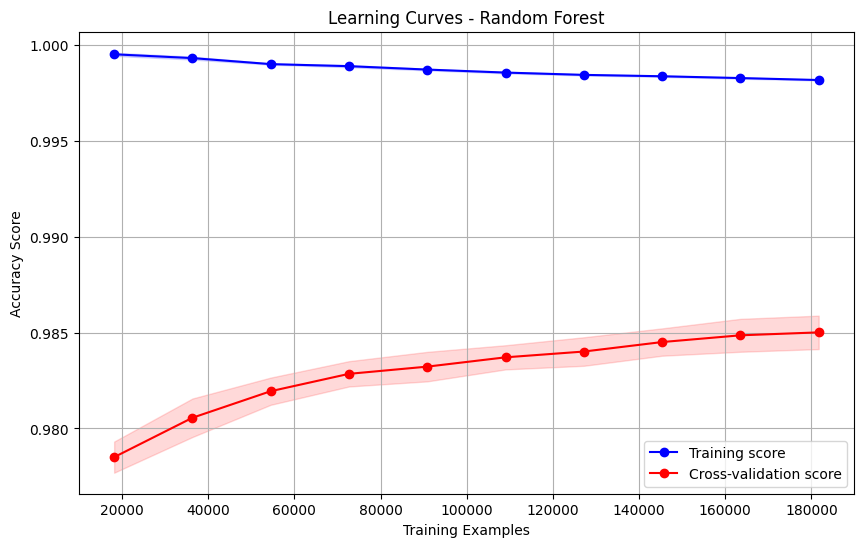

Training models:  50%|█████     | 2/4 [13:19<15:27, 463.54s/it]


Evaluating XGBoost with 10-fold cross-validation...

Time taken: 13.39 seconds


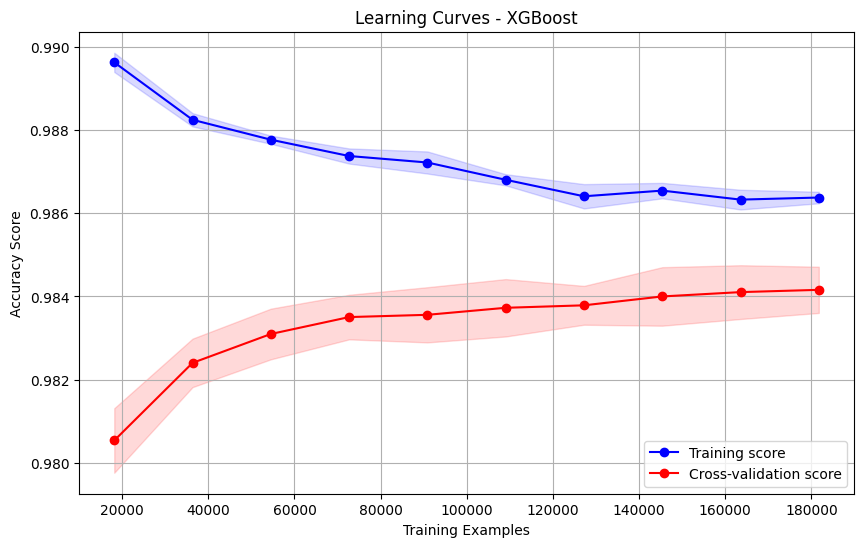

Training models:  75%|███████▌  | 3/4 [14:57<04:56, 296.72s/it]


Evaluating SVM with 10-fold cross-validation...
Optimizing SVM...
Using LinearSVC

Time taken: 44.62 seconds


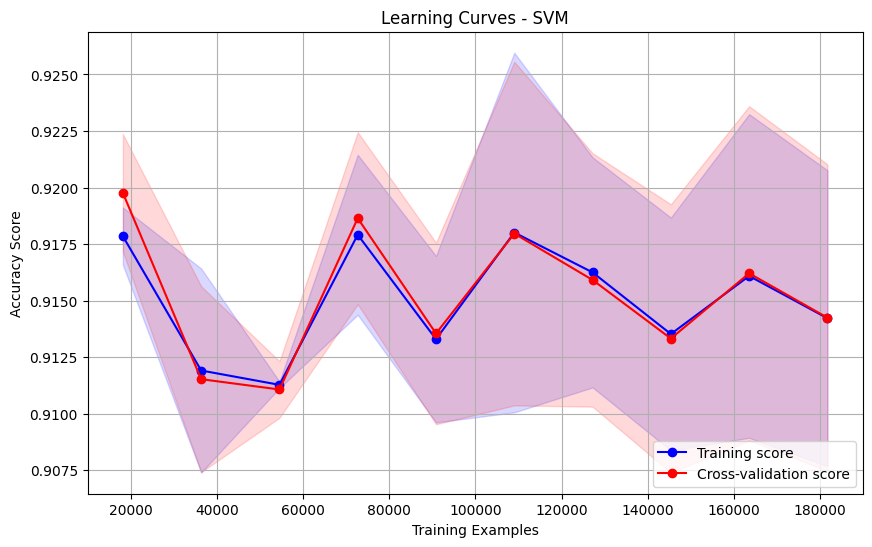

Training models: 100%|██████████| 4/4 [16:09<00:00, 242.42s/it]



Detailed Fold-by-Fold Performance:
        Model  Fold  accuracy  precision_weighted  recall_weighted  f1_weighted
Decision Tree     1     0.982               0.982            0.982        0.982
Decision Tree     2     0.982               0.982            0.982        0.982
Decision Tree     3     0.980               0.980            0.980        0.980
Decision Tree     4     0.980               0.980            0.980        0.980
Decision Tree     5     0.981               0.981            0.981        0.981
Decision Tree     6     0.983               0.983            0.983        0.983
Decision Tree     7     0.982               0.982            0.982        0.982
Decision Tree     8     0.983               0.983            0.983        0.983
Decision Tree     9     0.980               0.980            0.980        0.980
Decision Tree    10     0.981               0.981            0.981        0.981
Random Forest     1     0.984               0.984            0.984        0.984
Rand

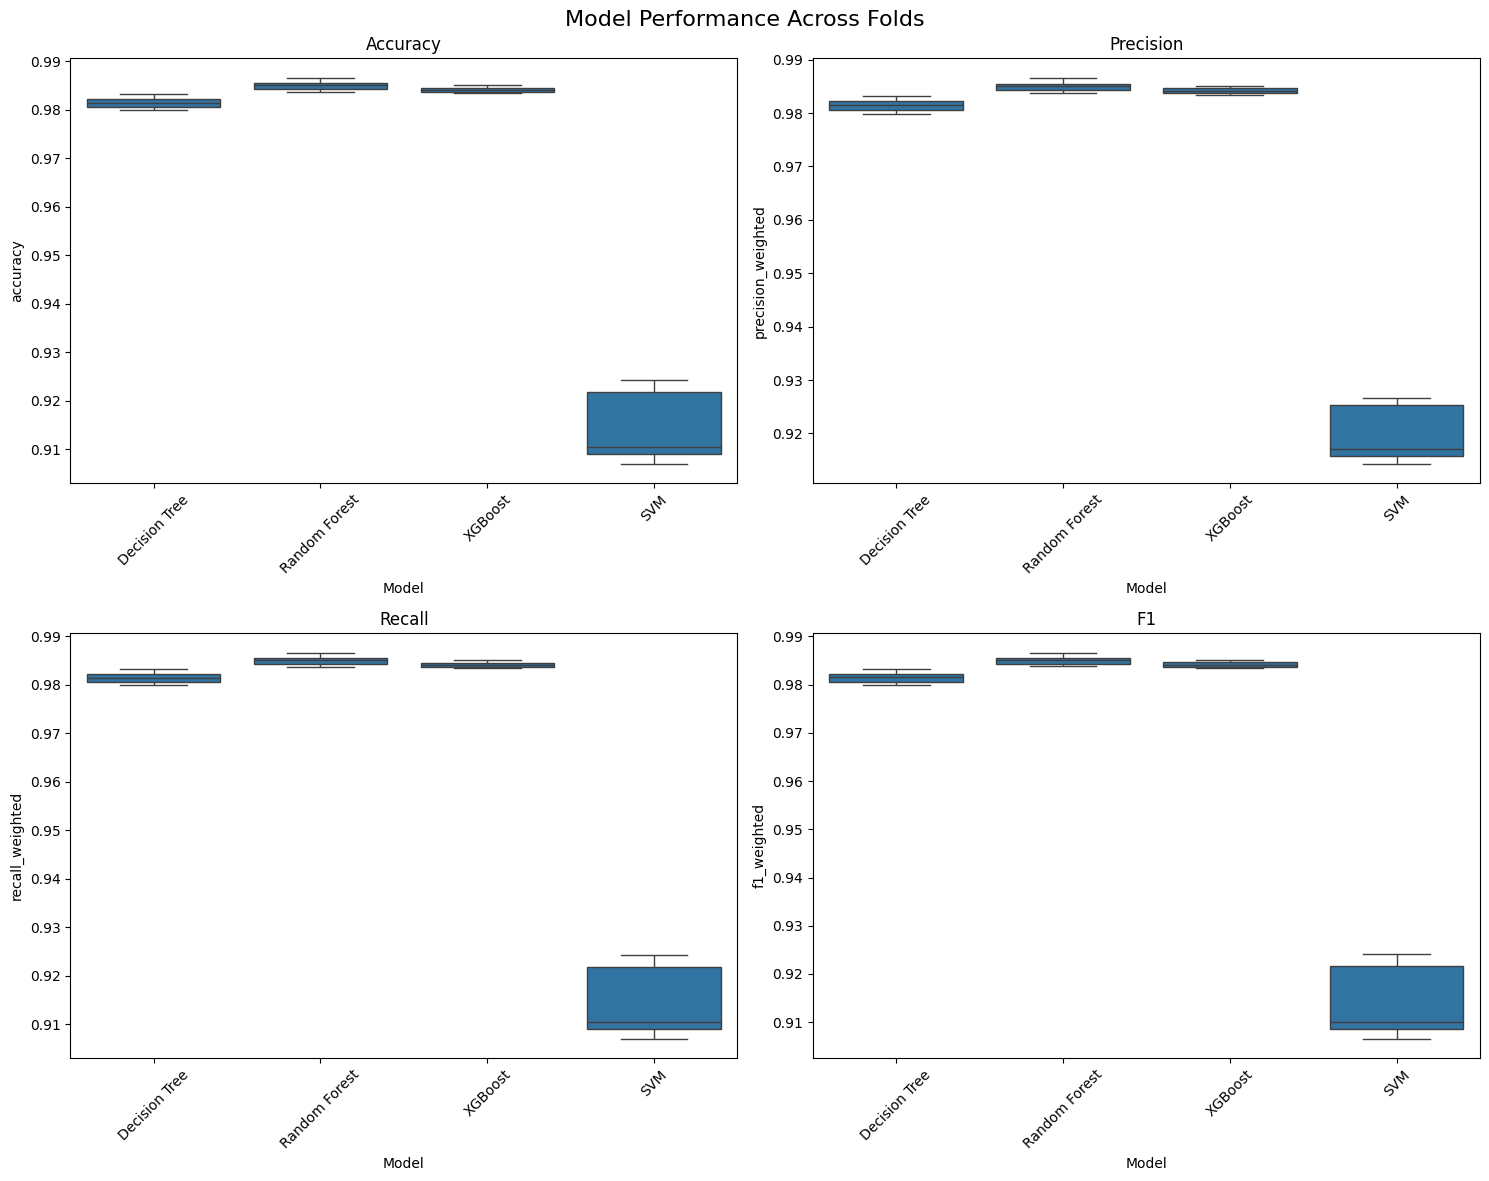

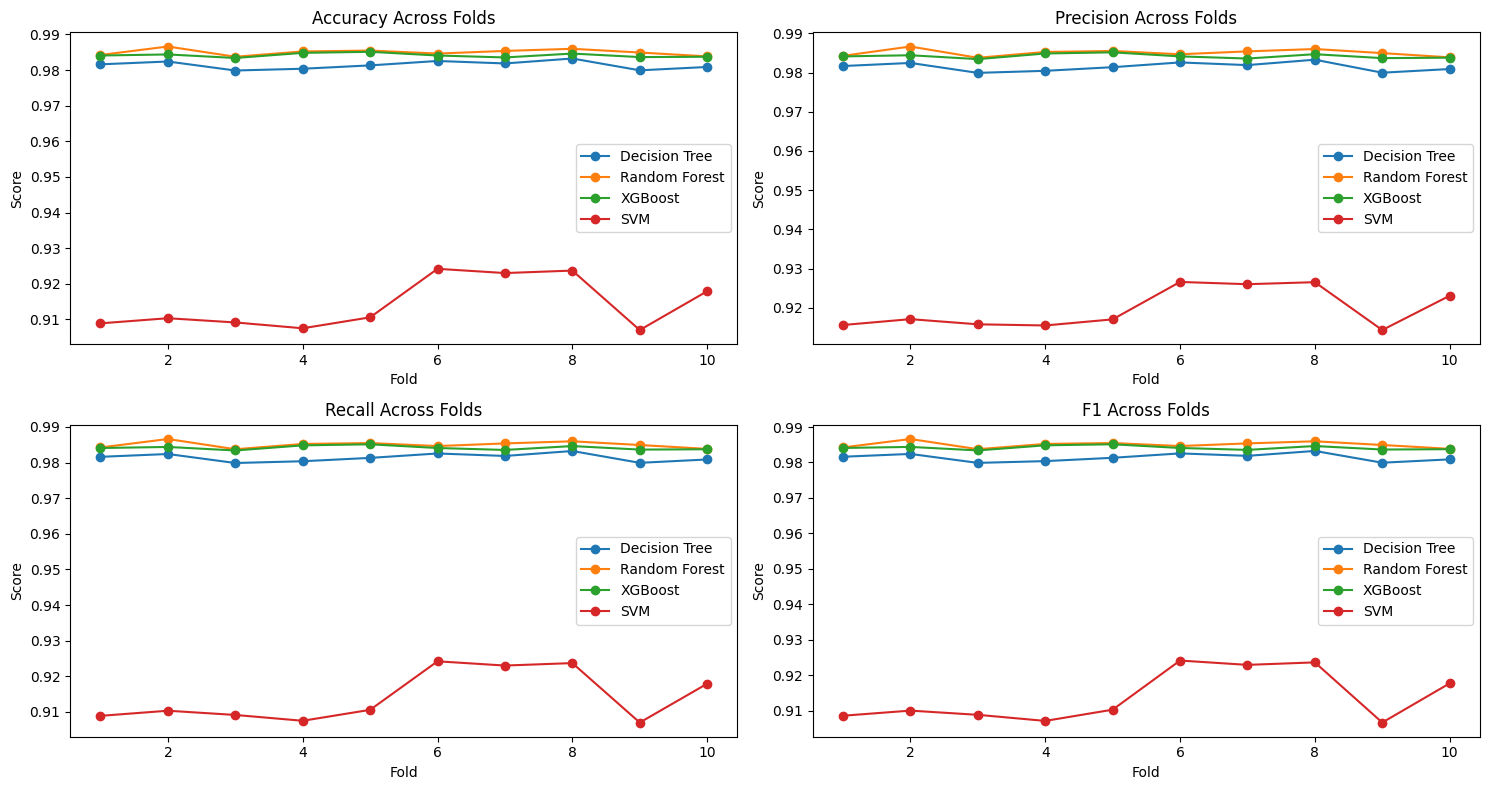


Best Model: Random Forest
F1 Score: 0.985
Model saved to: models/best_model_Random Forest.joblib


In [45]:
results, cv_results, fold_df, summary_df, best_model_name, model_path = train_and_evaluate_models_cv(X, y, feature_names)

In [46]:
def plot_xgboost_learning_curve_size(X, y, cv=10):
    """
    Plot XGBoost learning curve showing performance vs training set size using 10-fold CV
    """
    import xgboost as xgb
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import KFold

    # Define training sizes (10% to 100% of data)
    train_sizes = np.linspace(0.1, 1.0, 10)
    n_samples = len(X)

    # Initialize arrays to store scores
    train_scores = []
    val_scores = []

    # Create KFold cross-validator
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # For each training size
    for train_size in train_sizes:
        size_train_scores = []
        size_val_scores = []

        # Perform cross-validation
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            # Get initial train and validation sets for this fold
            X_train_fold, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Further subsample training data according to train_size
            n_train_samples = int(len(X_train_fold) * train_size)
            train_subsample = np.random.choice(len(X_train_fold), n_train_samples, replace=False)
            X_train = X_train_fold.iloc[train_subsample]
            y_train = y_train_fold.iloc[train_subsample]

            # Create DMatrix for XGBoost
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)

            # Set parameters
            params = {
                'objective': 'binary:logistic' if len(np.unique(y)) == 2 else 'multi:softmax',
                'num_class': len(np.unique(y)) if len(np.unique(y)) > 2 else None,
                'max_depth': 6,
                'learning_rate': 0.1,
                'eval_metric': ['error']
            }

            # Train model
            model = xgb.train(
                params,
                dtrain,
                num_boost_round=100,
                verbose_eval=False
            )

            # Get predictions and calculate accuracy
            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            # Calculate accuracies
            train_acc = np.mean((train_pred > 0.5) == y_train) if len(np.unique(y)) == 2 else \
                       np.mean(train_pred == y_train)
            val_acc = np.mean((val_pred > 0.5) == y_val) if len(np.unique(y)) == 2 else \
                     np.mean(val_pred == y_val)

            size_train_scores.append(train_acc)
            size_val_scores.append(val_acc)

        # Store mean scores for this training size
        train_scores.append(size_train_scores)
        val_scores.append(size_val_scores)

    # Convert to numpy arrays
    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    plt.figure(figsize=(10, 6))
    actual_train_sizes = [int(s * (n_samples * (cv-1)/cv)) for s in train_sizes]

    plt.plot(actual_train_sizes, train_mean, label='Training Accuracy', color='blue', marker='o')
    plt.fill_between(actual_train_sizes, train_mean - train_std, train_mean + train_std,
                     color='blue', alpha=0.1)

    plt.plot(actual_train_sizes, val_mean, label='Cross-validation Accuracy', color='red', marker='o')
    plt.fill_between(actual_train_sizes, val_mean - val_std, val_mean + val_std,
                     color='red', alpha=0.1)

    plt.title('XGBoost Learning Curve (10-fold CV)')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return train_sizes, train_mean, val_mean, train_std, val_std

# Usage example:
# train_sizes, train_scores, val_scores, train_std, val_std = plot_xgboost_learning_curve_size(X, y)

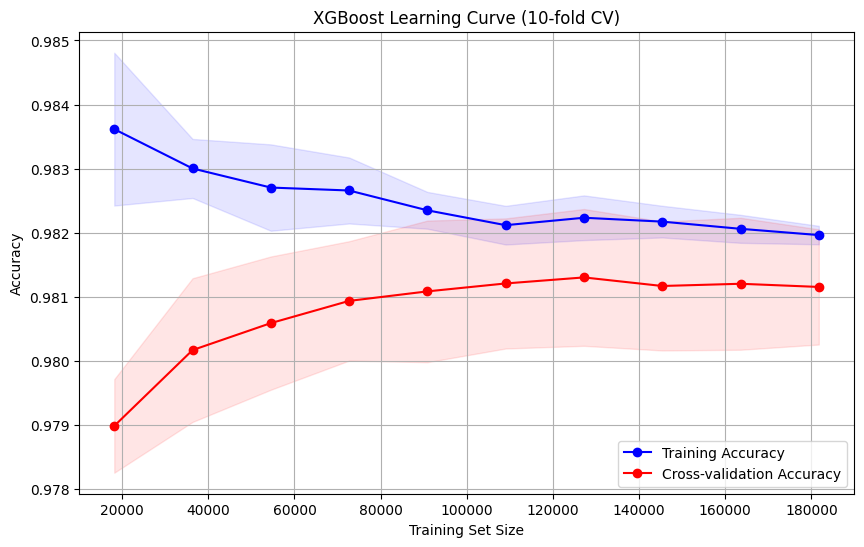

In [47]:
train_sizes, train_scores, val_scores, train_std, val_std = plot_xgboost_learning_curve_size(X, y)

In [48]:
results

{'Decision Tree': DecisionTreeClassifier(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 'SVM': LinearSVC(max_iter=2000, random_state=42)}

In [49]:
best_model_name

'Random Forest'

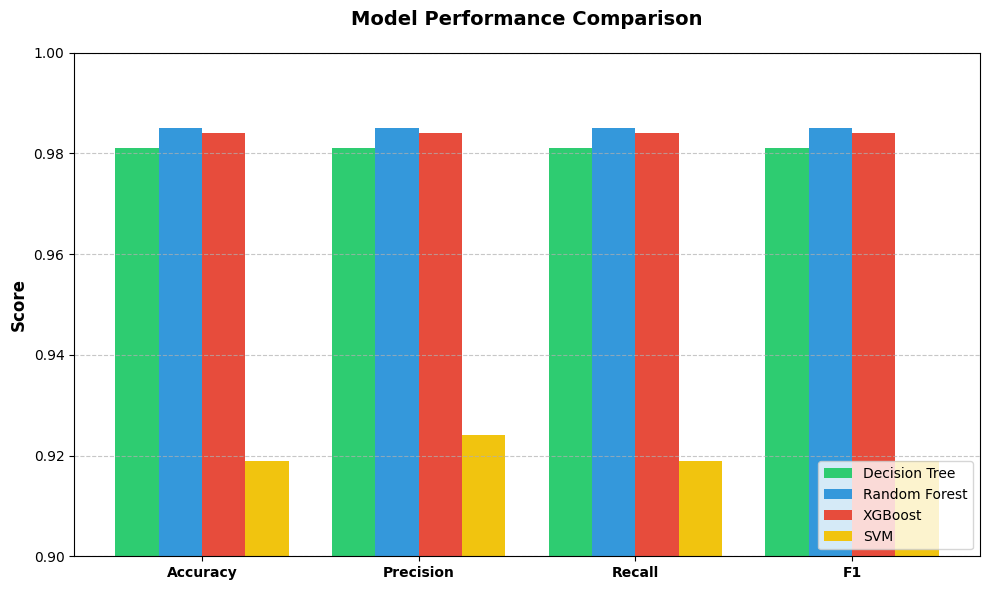

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create the data
data = {
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost', 'SVM'],
    'Accuracy': [0.981, 0.985, 0.984, 0.919],
    'Accuracy_std': [0.001, 0.001, 0.001, 0.006],
    'Precision': [0.981, 0.985, 0.984, 0.924],
    'Precision_std': [0.001, 0.001, 0.001, 0.005],
    'Recall': [0.981, 0.985, 0.984, 0.919],
    'Recall_std': [0.001, 0.001, 0.001, 0.006],
    'F1': [0.981, 0.985, 0.984, 0.919],
    'F1_std': [0.001, 0.001, 0.001, 0.006]
}

# Convert to DataFrame for easier handling
df = pd.DataFrame(data)

# Set up the plot style
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 6))

# Define positions for the bars
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics))
width = 0.2

# Plot bars for each model
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']
for i, model in enumerate(df['Model']):
    values = [df.loc[i, metric] for metric in metrics]
    ax.bar(x + i*width, values, width, label=model, color=colors[i])

# Customize the plot
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)

# Set x-axis ticks
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics, fontsize=10, fontweight='bold')

# Add legend inside the plot
ax.legend(loc='lower right')

# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits to focus on the relevant range
ax.set_ylim(0.90, 1.00)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

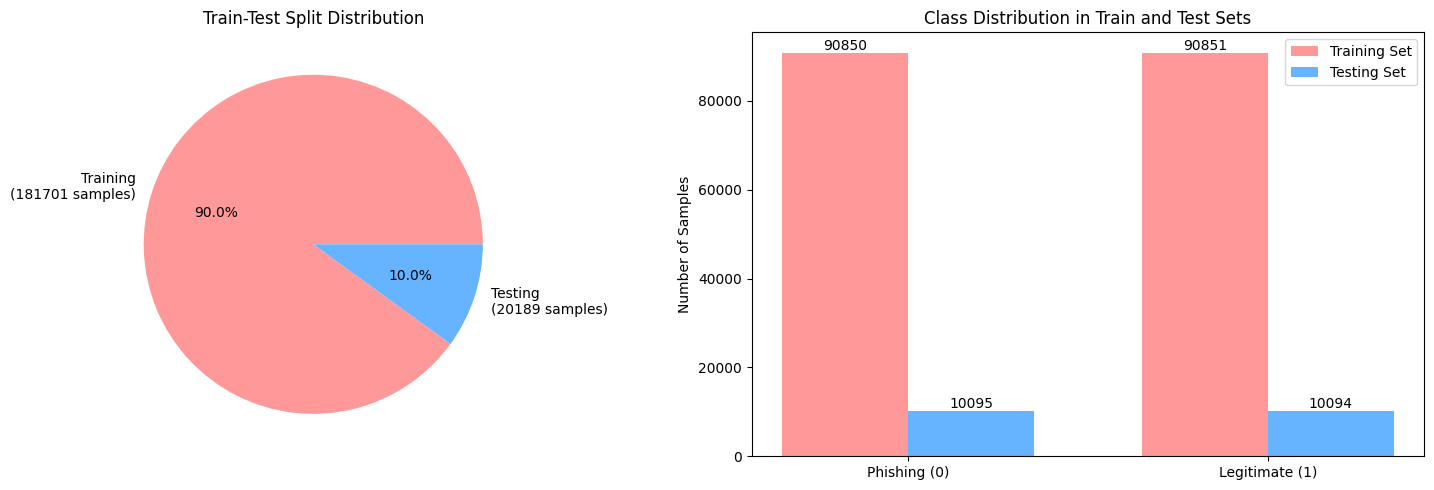

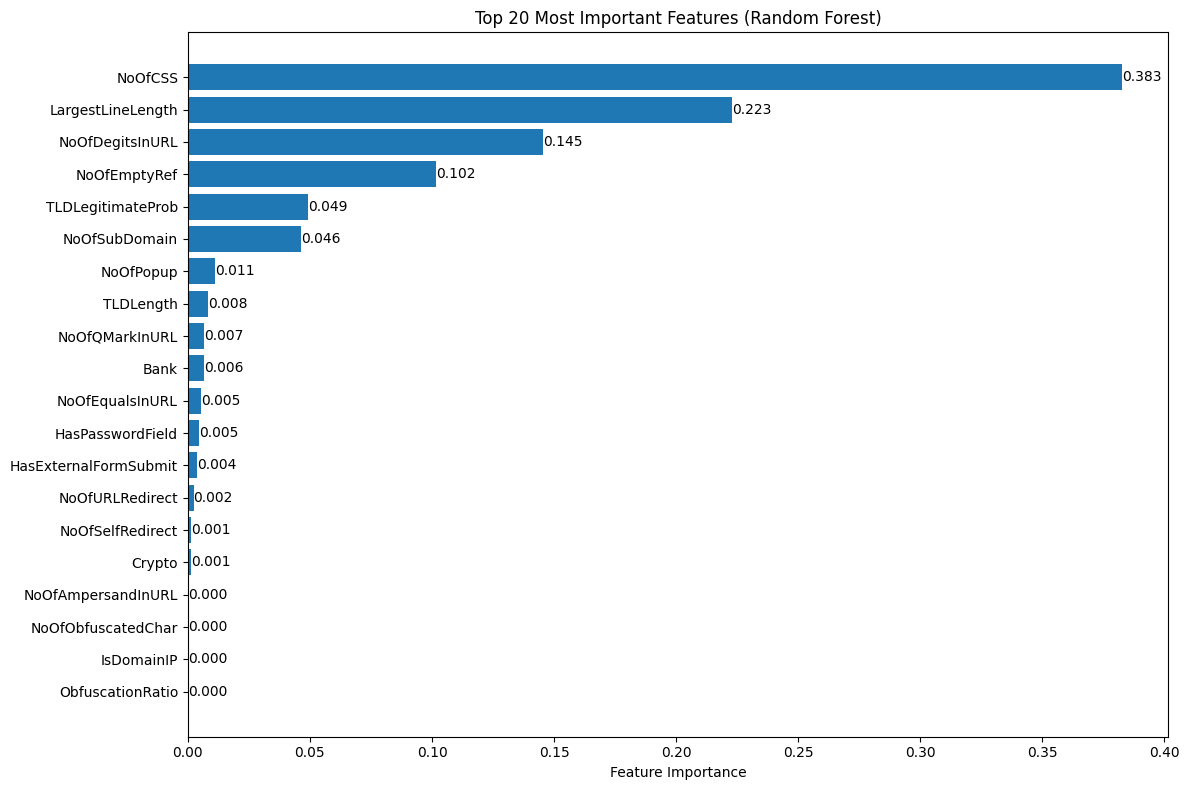

Model saved successfully!


In [51]:
# First plot the data distribution
def plot_data_distribution(X_train, X_test, y_train, y_test):
    """
    Create visualizations for data splitting distribution and class distribution
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Setup the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Train-Test Split Distribution
    split_sizes = [len(X_train), len(X_test)]
    labels = [f'Training\n({split_sizes[0]} samples)', f'Testing\n({split_sizes[1]} samples)']
    ax1.pie(split_sizes, labels=labels, autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
    ax1.set_title('Train-Test Split Distribution')

    # Plot 2: Class Distribution in Train and Test Sets
    train_class_dist = np.bincount(y_train)
    test_class_dist = np.bincount(y_test)

    x = np.arange(2)
    width = 0.35

    ax2.bar(x - width/2, train_class_dist, width, label='Training Set', color='#ff9999')
    ax2.bar(x + width/2, test_class_dist, width, label='Testing Set', color='#66b3ff')

    ax2.set_xticks(x)
    ax2.set_xticklabels(['Phishing (0)', 'Legitimate (1)'])
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('Class Distribution in Train and Test Sets')
    ax2.legend()

    # Add value labels on the bars
    for i, v in enumerate(train_class_dist):
        ax2.text(i - width/2, v, str(v), ha='center', va='bottom')
    for i, v in enumerate(test_class_dist):
        ax2.text(i + width/2, v, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def plot_rf_feature_importance(model, feature_names, top_n=20):
    """
    Create a detailed feature importance plot for Random Forest
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Select top N features
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_features = [feature_names[i] for i in top_indices]

    # Create DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': top_features,
        'Importance': top_importances
    })

    # Plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features (Random Forest)')

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}',
                ha='left', va='center', fontsize=10)

    plt.gca().invert_yaxis()  # Invert y-axis to show most important features at top
    plt.tight_layout()
    plt.show()

# First, show the data distribution
plot_data_distribution(X_train, X_test, y_train, y_test)

# Now train the Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Now plot the feature importance
plot_rf_feature_importance(rf_model, suitable_columns)

# Save the trained model
import joblib
joblib.dump(rf_model, 'models/best_model_Random Forest.joblib')
print("Model saved successfully!")

**MODE TESTING DEMO USING LLM CHATGPT COMPARISON**

In [52]:
X_url['label']= df_withURL['label']

In [53]:
model_path="/content/drive/MyDrive/url_phising_prj/models/best_model_Random Forest.joblib"

In [54]:
!pip install rapidfuzz

In [55]:
class PhishingDetector:
    def __init__(self, model_path, X_url_df):
        """
        Initialize the PhishingDetector with both URL and feature-based matching
        """
        self.model = joblib.load(model_path)
        self.X_url_df = X_url_df
        self.feature_columns = [
            'Bank', 'HasExternalFormSubmit', 'HasPasswordField', 'NoOfEmptyRef',
            'Crypto', 'TLDLegitimateProb', 'NoOfCSS', 'NoOfPopup', 'NoOfSubDomain',
            'NoOfObfuscatedChar', 'NoOfAmpersandInURL', 'LargestLineLength',
            'ObfuscationRatio', 'NoOfURLRedirect', 'HasObfuscation', 'IsDomainIP',
            'NoOfSelfRedirect', 'NoOfEqualsInURL', 'TLDLength', 'NoOfQMarkInURL',
            'NoOfDegitsInURL'
        ]

        # Preprocess URLs and create indices
        print("Preprocessing URLs...")
        self.X_url_df['processed_url'] = self.X_url_df['URL'].apply(self.preprocess_url)
        self._create_url_index()

        # Initialize feature-based matching
        print("Setting up feature-based matching...")
        self._setup_feature_matching()

    def _setup_feature_matching(self):
        """Setup for feature-based matching using NearestNeighbors"""
        # Extract features and scale them
        self.feature_matrix = self.X_url_df[self.feature_columns].fillna(0)
        self.scaler = StandardScaler()
        self.scaled_features = self.scaler.fit_transform(self.feature_matrix)

        # Initialize NearestNeighbors
        self.nn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')
        self.nn.fit(self.scaled_features)

    def _extract_url_features(self, url):
        """
        Extract available features from a URL without full HTML analysis
        Returns estimated features based on URL characteristics
        """
        features = {}

        # URL-based features we can extract directly
        features['NoOfSubDomain'] = url.count('.') - 1 if '.' in url else 0
        features['NoOfAmpersandInURL'] = url.count('&')
        features['NoOfEqualsInURL'] = url.count('=')
        features['NoOfQMarkInURL'] = url.count('?')
        features['NoOfDegitsInURL'] = sum(c.isdigit() for c in url)
        features['IsDomainIP'] = 1 if all(part.isdigit() for part in url.split('.')[0].split(':')[-1].split('.')) else 0

        # TLD-related features
        tld = url.split('.')[-1] if '.' in url else ''
        features['TLDLength'] = len(tld)

        # Set reasonable defaults for other features
        defaults = {
            'Bank': 0,
            'HasExternalFormSubmit': 0,
            'HasPasswordField': 0,
            'NoOfEmptyRef': 0,
            'Crypto': 0,
            'TLDLegitimateProb': 0.5,
            'NoOfCSS': 0,
            'NoOfPopup': 0,
            'NoOfObfuscatedChar': 0,
            'LargestLineLength': 0,
            'ObfuscationRatio': 0,
            'NoOfURLRedirect': 0,
            'HasObfuscation': 0,
            'NoOfSelfRedirect': 0
        }

        # Update features with defaults
        for key, value in defaults.items():
            if key not in features:
                features[key] = value

        # Ensure all feature columns are present and in correct order
        ordered_features = {col: features.get(col, 0) for col in self.feature_columns}
        return ordered_features

    def find_similar_by_features(self, url_features):
        """
        Find similar URLs based on features when URL matching fails
        """
        # Create DataFrame with correct column names
        feature_df = pd.DataFrame([url_features], columns=self.feature_columns)

        # Scale the input features
        scaled_vector = self.scaler.transform(feature_df)

        # Find nearest neighbors
        distances, indices = self.nn.kneighbors(scaled_vector)

        # Get the best match
        best_idx = indices[0][0]
        similarity_score = 1 / (1 + distances[0][0])  # Convert distance to similarity score

        # Get features from the best match
        best_features = self.X_url_df.iloc[best_idx][self.feature_columns].to_dict()
        best_url = self.X_url_df.iloc[best_idx]['URL']

        return best_url, similarity_score * 100, best_features

    def predict(self, features):
        """Make prediction using the loaded model"""
        # Create DataFrame with correct column names
        feature_df = pd.DataFrame([features], columns=self.feature_columns)
        prediction = self.model.predict(feature_df)[0]
        probability = self.model.predict_proba(feature_df)[0]
        return prediction, probability

    def check_url(self, input_url):
        """Enhanced main method to check if a URL is potentially phishing"""
        # First try URL-based matching
        matched_url, similarity, features = self.find_closest_match(input_url)

        # If no good URL match found, try feature-based matching
        if matched_url is None:
            print("No close URL match found, trying feature-based matching...")
            # Extract available features from the input URL
            url_features = self._extract_url_features(input_url)
            matched_url, similarity, features = self.find_similar_by_features(url_features)

        # Make prediction
        prediction, probabilities = self.predict(features)

        return {
            "status": "Analysis complete",
            "input_url": input_url,
            "matched_url": matched_url,
            "similarity_score": similarity,
            "match_type": "URL-based" if similarity > 60 else "Feature-based",
            "prediction": "Phishing" if prediction == 0 else "Legitimate",
            "confidence": float(max(probabilities)),
            "features_used": features
        }
    def _create_url_index(self):
        """Create indices for faster URL matching"""
        self.domain_index = defaultdict(list)
        self.length_index = defaultdict(list)

        for idx, row in enumerate(self.X_url_df['processed_url']):
            # Index by domain
            try:
                domain = row.split('/')[0]
                self.domain_index[domain].append(idx)
            except:
                continue

            # Index by URL length (for quick filtering)
            url_len = len(row)
            len_bucket = url_len // 5  # Group URLs by length ranges
            self.length_index[len_bucket].append(idx)

    def preprocess_url(self, url):
        """Optimized URL preprocessing"""
        if pd.isna(url):
            return ""
        url = str(url).lower().strip()
        url = re.sub(r'(https?://)?(www\.)?', '', url)
        url = re.sub(r'/+$', '', url)
        return url

    def _calculate_similarity(self, processed_input, idx):
        """Calculate similarity score for a single URL"""
        url = self.X_url_df.iloc[idx]['processed_url']
        # Use rapidfuzz instead of fuzzywuzzy for better performance
        similarity = rapidfuzz.ratio(processed_input, url)
        return idx, similarity

    def _get_candidate_indices(self, processed_input):
        """Get candidate URLs for comparison based on indexing"""
        candidates = set()

        # Get URLs with similar length
        input_len = len(processed_input)
        len_bucket = input_len // 5
        for bucket in [len_bucket - 1, len_bucket, len_bucket + 1]:
            candidates.update(self.length_index.get(bucket, []))

        # Get URLs with same domain
        try:
            domain = processed_input.split('/')[0]
            candidates.update(self.domain_index.get(domain, []))
        except:
            pass

        return list(candidates)

    def find_closest_match(self, input_url, threshold=80):
        """
        Optimized closest match finding using parallel processing and indexing
        """
        processed_input = self.preprocess_url(input_url)

        # Get candidate URLs using indices
        candidate_indices = self._get_candidate_indices(processed_input)

        if not candidate_indices:
            return None, 0, None

        # Use multiple threads to calculate similarities
        with ThreadPoolExecutor(max_workers=min(multiprocessing.cpu_count(), 8)) as executor:
            similarity_func = partial(self._calculate_similarity, processed_input)
            similarities = list(executor.map(similarity_func, candidate_indices))

        # Find best match
        best_idx, best_score = max(similarities, key=lambda x: x[1])

        if best_score >= threshold:
            best_row = self.X_url_df.iloc[best_idx]
            feature_cols = [col for col in self.X_url_df.columns if col not in ['URL', 'processed_url']]
            best_features = best_row[feature_cols].to_dict()
            return best_row['URL'], best_score, best_features

        return None, 0, None

In [56]:
detector = PhishingDetector(model_path, X_url)

Preprocessing URLs...
Setting up feature-based matching...


In [57]:
def run_cli(detector):
    print("\n=== Phishing URL Detector ===")
    print("Type 'quit' to exit")

    while True:
        url = input("\nEnter URL to check: ").strip()

        if url.lower() in ['quit', 'exit', 'q']:
            print("Goodbye!")
            break

        if url:
            print("\nAnalyzing URL...")
            result = detector.check_url(url)

            print("\nResults:")
            print(f"URL: {result['input_url']}")
            print(f"Prediction: {result['prediction']}")
            print(f"Confidence: {result['confidence']*100:.2f}%")
            print(f"Match Type: {result['match_type']}")
            print(f"Similarity Score: {result['similarity_score']:.2f}%")

# Usage
if __name__ == "__main__":
    run_cli(detector)


=== Phishing URL Detector ===
Type 'quit' to exit

Enter URL to check: quit
Goodbye!


# EVALUATION OF CHATGPT PERFROMANCE

In [58]:
df_withURL

,URL,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
136221,https://www.northcm.ac.th,24,17,0,100.000000,0.800000,0.000510,0.064490,2,2,...,0,0,1,47,3,4,69,7,115,1
56609,https://unitedmartialartscenters.com/at0/mygov...,59,28,0,33.522664,1.000000,0.522907,0.060027,3,0,...,1,0,1,0,2,0,0,0,1,0
46393,https://email.mail1.onesignal.os.tc/c/ejwcz02u...,385,27,0,3.199329,0.458333,0.000046,0.034325,2,3,...,0,0,0,0,0,0,0,0,1,0
129746,http://uqr.to/1il1z,19,6,0,53.846154,1.000000,0.000896,0.036850,2,0,...,0,0,0,0,0,0,1,0,1,0
131464,https://www.woolworthsrewards.com.au,35,28,0,100.000000,0.857143,0.010086,0.060894,2,2,...,1,0,1,33,7,8,15,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54886,http://www.ota-relay.com,23,17,0,69.230769,0.666667,0.522907,0.070378,3,1,...,0,0,0,0,0,0,0,0,0,0
207892,https://kjdhguh.dfhruty.repl.co/,32,23,0,34.593573,0.400000,0.005977,0.039281,2,2,...,0,0,0,0,0,0,0,0,2,0
110268,https://www.slavevoyages.org,27,20,0,100.000000,1.000000,0.079963,0.059055,3,1,...,0,0,1,23,3,6,71,12,28,1
103694,https://www.leadcastingcall.com,30,23,0,100.000000,1.000000,0.522907,0.063148,3,1,...,0,0,1,25,9,22,87,1,93,1


In [59]:
# test samples

test_samples=df_withURL[['URL','label']].sample(50, random_state=42)

In [60]:
test_samples

,URL,label
2417,https://www.omahanewsbulletin.com,0
150551,https://www.nnmclub.to,1
56713,https://www.oopiee.net,1
156517,https://pages-help-services.start.page/,0
95046,https://drive.dataexpertservices.hu/login1/i/f...,0
229653,http://43.159.48.238/servicelogin?passive=1209...,0
56692,https://www.mailasail.com,1
72631,https://www.wildsanctuary.com,1
129764,https://www.iucnosgbull.org,1
87361,https://www.governor.nd.gov,1


In [61]:
urls = test_samples['URL'].tolist()


In [62]:
urls

['https://www.omahanewsbulletin.com',
 'https://www.nnmclub.to',
 'https://www.oopiee.net',
 'https://pages-help-services.start.page/',
 'https://drive.dataexpertservices.hu/login1/i/flow/login.php',
 'http://43.159.48.238/servicelogin?passive=1209600&amp;continue=https://accounts.google.com/?&amp;xrealip=35.203.255.103&amp;followup=https://accounts.google.com/?&amp;xrealip=35.203.255.103',
 'https://www.mailasail.com',
 'https://www.wildsanctuary.com',
 'https://www.iucnosgbull.org',
 'https://www.governor.nd.gov',
 'http://www.moneytrade.trade',
 'http://www.kuerennkaycoato.co.jp.kuercnnkayceata.ltvfag.top/ai/?authenticated=true&openid/gp/signin/x&i=a&oauth=m&i?ie=utf8&ref_=rhf_custrec_signin7512674f779447ec8be959a119cf4c6e9ea5b9ca',
 'http://www.allindiapoint.com',
 'https://www.stephenearp.com',
 'https://sitebuilder184498.dynadot.com/',
 'http://www.alflying.win',
 'http://www.m-analytics.net',
 'http://stonex-payments.net',
 'http://www.lj9z.ybngb.com',
 'https://www.campustimesp

**GPT PREDICTIONS**

1. https://www.asherguitars.com - 0
2. https://storageapi.fleek.one/777e225c-8a42-4050-a6a6-7ba75cb11438-bucket/nofficeline.html - 1
3. https://zimbraccount03650.firebaseapp.com/ - 1
4. https://www.olivertacke.de - 0
5. http://www.o000.xyz - 1
6. http://www.travelwadi.com - 0
7. https://minhnguyenvn.ml/rabi/team/ypfzrw/zeynep.cigdem@omya.com?id=com.google.android.apps.youtube.music - 1
8. https://www.art-of-war.jp - 0
9. https://www.festivalberlioz.com - 0
10. https://mynembercard.point.soumu.jo.diujiang.cn/ - 1
11. https://www.bataan.gov.ph - 0
12. http://www.kuerennkaycoato.co.jp.kuercnnkayceata.ltvfag.top/ai/?authenticated=true&openid/gp/signin/x&i=a&oauth=m&i?ie=utf8&ref_=rhf_custrec_signin7512674f779447ec8be959a119cf4c6e9ea5b9ca - 1
13. http://www.digivietnam.com - 0
14. http://www.suxjweyfm.ga - 1
15. https://therapeutic-marble-wormhole.glitch.me/taylor-wessing.html - 1
16. https://www.sweharris.org - 0
17. https://www.equalnationalityrights.org - 0
18. https://www.on-camera-audiences.com - 0
19. https://www.joeydevilla.com - 0
20. http://www.hotball.top - 1
21. https://www.gcsp.ch - 0
22. https://www.testpoint.com - 0
23. https://www.arnoldshomeimprovement.com - 0
24. https://www.hollywoodchicago.com - 0
25. http://www.server1.wyeetacs.com.au - 1
26. http://www.lms.fburl.fun - 1
27. http://www.amazceozm-co-jp.amazzeocn.50220.top/ - 1
28. https://www.taramillsauthor.com - 0
29. https://www.simply.cash - 0
30. http://ethereumuma.com - 1
31. https://ophoudloging.gitbook.io/ - 1
32. https://www.smartcapitalmind.com - 0
33. http://vn10022023vn-apps-1312962597.cos.sa-saopaulo.myqcloud.com/fx.htm - 1
34. https://www.aapfco.org - 0
35. https://www.hubspot.com - 0
36. http://www.bundleddeal.com - 0
37. http://www.liveoffice365.me - 1
38. https://www.edelcollecties.nl - 0
39. https://business01872961.firebaseapp.com/ - 1
40. https://www.obggames.fun - 1
41. https://swfu9awmm.firebaseapp.com/ - 1
42. https://www.upnm.edu.my - 0
43. http://suporte72horas.com - 1
44. https://www.valeriocappelli.it - 0
45. http://mingovplvdss.worldrivforreiglich.ga/ - 1
46. https://www.svenskfilmdatabas.se - 0
47. https://scqj-ao3h-b.web.app/ - 1
48. https://bafkreifedp6nzvvpctiqkdtplrpdkt32rf7nsuvlvu5chhio3awenctwdy.ipfs.dweb.link/ - 1
49. http://www.geoffoglemusic.com - 0
50. https://www.killerinstinctcentral.com - 0




In [63]:
chatgpt_pred=[1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]

In [64]:
# Add predictions to DataFrame
test_samples['chatgpt_predictions'] = chatgpt_pred

# Evaluate predictions
from sklearn.metrics import classification_report

print(classification_report(test_samples['label'], test_samples['chatgpt_predictions']))

              precision    recall  f1-score   support

           0       0.42      0.42      0.42        24
           1       0.46      0.46      0.46        26

    accuracy                           0.44        50
   macro avg       0.44      0.44      0.44        50
weighted avg       0.44      0.44      0.44        50



In [65]:
test_samples

,URL,label,chatgpt_predictions
2417,https://www.omahanewsbulletin.com,0,1
150551,https://www.nnmclub.to,1,0
56713,https://www.oopiee.net,1,0
156517,https://pages-help-services.start.page/,0,1
95046,https://drive.dataexpertservices.hu/login1/i/f...,0,0
229653,http://43.159.48.238/servicelogin?passive=1209...,0,1
56692,https://www.mailasail.com,1,0
72631,https://www.wildsanctuary.com,1,1
129764,https://www.iucnosgbull.org,1,1
87361,https://www.governor.nd.gov,1,0
